# Corpus 전처리

현재 데이터는 xlsx로 저장이 되어 있다. <br/><br/>COCA 코퍼스와 같은 영어 corpus와 비교 예정이기에 전처리가 필요한데, 이를 위해 데이터 저장 포멧은 크게 3가지가 있고 아래와 같다. <br/> <br/> <br/> 1. csv: 엑셀로 읽을 수 있으며 가독성이 좋다. 테이블 형식의 데이터 정리에 유용. <br/> 2. parquet: 하둡과 같은 프레임 워크를 위해 개발된 데이터 압축 형태이고, 압축이 가장 잘되는 열 방향 데이터 정보 포멧. <br/> 3. json: 일반적으로 CS 분야에서 통신이나 테이블 형태가 아닌 데이터 저장에 많이 사용되는 형태. 압축률이 좋지는 않으나 유연한 구조로 인해 확장이 쉽다.<br/><br/> <br/> 고로 이번에는 json으로 사용하려고 한다.

## 개발 환경 세팅

python을 언어로 사용할 거고, uv를 사용해 필요한 라이브러리를 다운로드할 것이다. 
<br/> uv 란? -> python 라이브러리를 굉장히 빨리 다운로드해주는 pkg-manager
<br/> 혹시라도 읽고 계신 분이 CS 분야 전공자라면, 부디 쓰시길 바랍니다. conda, pip 대비 비교도 안될 정도로 빠릅니다,,

만약 github에서 pull하고 사용 중이라면 pyproject.toml 파일을 열어보면 dependencies에서 라이브러리 이름을 확인할 수 있을 텐데 그게 꼭 설치되어야 아래가 진행 가능하다!!!

## 데이터 전처리 전략 및 순서

전처리 순서는 아래와 같다.<br/><br/><br/> 1. 문잔 단위 분할 <br/> 2. 단어 단위 분할 및 품사 태깅

### 문장 기준 분할

수능 영어 듣기 corpus: csat_listening_article

### 라이브러리 import

In [230]:
import nltk # Natural Language Toolkit
import contractions # 영어 줄임말 풀기
import pandas as pd # 데이터 처리
import numpy as np # 데이터 처리
import seaborn as sns # 데이터 시각화
from tqdm import tqdm # 데이터 처리
import re # 정규식으로 특수기호 및 char 처리
import json # 데이터 가공 후 저장할 형식
from typing import Any, Dict, List  # python data-type 정의
from pathlib import Path # 파일 경로 처리
import os # 파일 경로 및 처리
from sklearn.preprocessing import StandardScaler # 전처리 시 normalize

## preprocessor class

In [12]:
class Preprocessor:
    def __init__(self, type:str):
        # corpus 종류에 따라 구분 / 수능 or 교과서
        if type not in ['test', 'textbook']:
            raise ValueError('type must be either "test" or "textbook"')     # 둘 다 아니라면,,
        self.type = type
        
        # nltk에서 제공하는 tokenizer와 tagger를 다운로드: 
        try:
            nltk.download('punkt')  
            nltk.download('punkt_tab')
            nltk.download('averaged_perceptron_tagger_eng')
        except:
            pass
        
    def split_sentences(self, text: str) -> list: # 여러 문장을 각각의 문장으로 분리
        return nltk.sent_tokenize(text)
    
    def tokenize_sentence(self, sentence: str) -> list: # str 형태의 문장은 단어별 품사 태깅(single sentence)
        tokens = nltk.word_tokenize(sentence) # tokenize sentence -> word level
        tagged = nltk.pos_tag(tokens, lang='eng') # tagging the word -> pos(품사) level
        return tagged
    
    def split_word_pos(self, tagged: list) -> list: # 위의 정보를 단어와 품사로 분리
        word_list, pos_list = [], [] # 각각 단어와 품사를 저장할 리스트
        for word, pos in tagged:    # token과 품사 정보를 분리하여 저장.
            word_list.append(word)
            pos_list.append(pos)
        return word_list, pos_list
    
    def change_data_type(self, corpus: pd.DataFrame): # 열 별 데이터 타입 수정.
        
        if self.type == 'test': # 수능 읽기 혹은 듣기 지문
            if '년도' in corpus.columns:    # 수능 읽기, 듣기 지문 파일에만 적용!!
                corpus['년도'] = corpus['년도'].astype('int')
                corpus['월'] = corpus['월'].astype('int')
                corpus['번호'] = corpus['번호'].astype('int')

                corpus = corpus.astype({
                    '년도': 'str',
                    '월': 'str',
                    '번호': 'str',
                    '출처': 'str',
                    '비고': 'str',
                    '본문': 'str'
                })
        elif self.type == 'textbook': # 영어 교과서
            corpus = corpus.astype({
                '출처': 'str',
                '비고': 'str',
                '본문': 'str'})
        

        return corpus
        
    def fillter_values(self, df: pd.DataFrame): # 일부 열 형식 정리
        
        # 숫자만 해당하는 정규식
        number_expression = r'^\d+'

        if self.type == 'test': # 수능 관련 지문들만 처리,,
            if '년도' not in df.columns:    # 해당 파일들은 '년도' column이 있을 테니,,
                raise ValueError('년도 열이 없습니다.')

            for idx, row in tqdm(df.iterrows(), desc='데이터 형식 통일 중..', total=len(df)):
                # NaN, null 값을 채운다.
                if row['본문'] is None: # 혹시라도 본문이 없는 row면 pass
                    continue

                # 모든 정보가 다 있는 경우, 
                if not np.isnan(row['년도']):   # 년도 정보가 없다면 바로 이전 row에서 참고
                    if type(row['년도']) == str:
                        df.loc[idx, '년도'] = re.search(number_expression, row['년도']).group()
                    if type(row['월']) == str:
                        df.loc[idx, '월'] = re.search(number_expression, row['월']).group()
                    if type(row['번호']) == str:
                        df.loc[idx, '번호'] = re.search(number_expression, row['번호']).group()
                    if type(row['출처']) == str:
                        if '수능' in row['출처']:
                            df.loc[idx, '출처'] = '수능'
                        elif '모의' in row['출처']:
                            df.loc[idx, '출처'] = '모의'
                        else:
                            pass
                
                # 일부 정보가 없는 경우
                else:   # 년도 정보가 없다면 바로 이전 row에서 참고
                    df.loc[idx, '년도'] = df.loc[idx-1, '년도']
                    df.loc[idx, '월'] = df.loc[idx-1, '월']
                    df.loc[idx, '출처'] = df.loc[idx-1, '출처']
                    if df.loc[idx, '비고'] is None:
                        df.loc[idx, '비고'] = "."
        
        elif self.type == 'textbook':
            if '저자' not in df.columns:    # 해당 파일들은 '저자' column이 있을 테니,,
                raise ValueError('저자 열이 없습니다.')
            
            remove_row_idxs = []    # 본문이 없는 열들 번호를 저장할 리스트
            sources = [] # 출처 정보를 통합하여 저장할 리스트
            notes = [] # 비고 정보 저장 열
            
            for idx, row in tqdm(df.iterrows(), desc='데이터 형식 통일 중..', total=len(df)):
                
                if row['본문'] is None: # 혹시라도 본문이 없는 row면 collect
                    remove_row_idxs.append(idx)
                
                if row['출판사'] is None:   # 메타 정보 중 일부가 None이라면 str _ 값으로 대체
                    row['출판사'] = '_'
                if row['저자'] is None:
                    row['저자'] = '_'
                if row['과정'] is None:
                    row['과정'] = '_'
                if row['교과서'] is None:
                    row['교과서'] = '_'
                if row['단원'] is None:
                    row['단원'] = '_'
                elif type(row['단원']) != str:
                    row['단원'] = str(row['단원'])
                if row['단원명'] is None:
                    row['단원명'] = '_'
                if row['본문제목'] is None:
                    row['본문제목'] = '_'
                
                source = f"{row['출판사']} {row['저자']} {row['과정']} {row['교과서']}"
                sources.append(source)

                if row['비고'] is None:
                    row['비고'] = '.'
                note = f"{row['단원']} {row['단원명']} {row['본문제목']} / {row['비고']}"
                notes.append(note)
            
            
            # 출처 정보 추가 및 불필요 열 제거
            df['출처'] = sources
            df['비고'] = notes
            df = df.drop(index=remove_row_idxs)
            df = df.drop(columns=['출판사', '저자', '과정', '교과서', '단원', '단원명', '본문제목'])
        
        else:
            raise ValueError('type must be either "test" or "textbook"')
        
        return df

    def generate_json_data(self, id: int, text:str, tokens:list, pos_tags:list, metadata:dict) -> dict:
        """
        주어진 행의 데이터를 JSON 형식으로 변환하는 함수
        
        Args:
            text (str): 원본 텍스트
            tokens (list): 토큰 리스트
            pos_tags (list): 품사 태깅 리스트
            metadata (dict): 메타데이터
        """ 
        
        return {
            "id": id,
            "text": text,
            "tokens": tokens,
            "pos_tags": pos_tags,
            "metadata": metadata
        }

    def get_gender(self, text: str) -> str: # 문장 내에서 화자 성별 탐지
        if 'M:' in text or 'M ' in text:
            return 'M'
        elif 'W:' in text or 'W ' in text:
            return 'W'
        else:
            return 'N'


In [3]:
# sample
preprocessor = Preprocessor()
text = "I am a student. I am a professor."

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [4]:
# example
sentences = preprocessor.split_sentences(text)
for sentence in sentences:
    #print(preprocessor.tokenize_sentence(sentence))
    print(preprocessor.split_word_pos(preprocessor.tokenize_sentence(sentence)))

(['I', 'am', 'a', 'student', '.'], ['PRP', 'VBP', 'DT', 'NN', '.'])
(['I', 'am', 'a', 'professor', '.'], ['PRP', 'VBP', 'DT', 'NN', '.'])


예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

## 수능 Corpus 전처리

In [5]:
# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel('csat_listening_article.xlsx')
listening_article

,년도,월,번호,출처,본문,비고
0,2016.0,11,1.0,수능,"W: Charlie, where did you get these apples? Th...",.
1,NaN,NaN,2.0,NaN,M: Excuse me. I see the 2 o’clock flight to Da...,.
2,NaN,NaN,3.0,NaN,"W: Hello, listeners! This is One Minute Health...",.
3,NaN,NaN,4.0,NaN,"M: Ms. Robinson, what was your opinion of Mr. ...",.
4,NaN,NaN,5.0,NaN,"W: How was everything, Mr. Silverman? \nM: Goo...",.
...,...,...,...,...,...,...
1302,NaN,NaN,13.0,NaN,① W: What can I do for you today?\nM: I'd like...,그림의 상황에 적절한 대화를 고르는 문제 / 답 4
1303,NaN,NaN,14.0,NaN,W: You must be my new next door neighbor. Welc...,NaN
1304,NaN,NaN,15.0,NaN,"W: Hey, Joe. How are you doing?\nM: Hi, Michel...",NaN
1305,NaN,NaN,16.0,NaN,"W: Peter, how's the planning for the school fe...",NaN


In [6]:
# 전체 행은 1307, 본문이 있는 행은 1234 -> 본문이 있는 행만 기준으로 처리
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      77 non-null     float64
 1   월       77 non-null     object 
 2   번호      1306 non-null   float64
 3   출처      77 non-null     object 
 4   본문      1234 non-null   object 
 5   비고      1291 non-null   object 
dtypes: float64(2), object(4)
memory usage: 61.4+ KB


In [7]:
# 결측치 제거 후 불필요 행 지우기
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')

NaN 값 채우기: 100%|██████████| 1307/1307 [00:00<00:00, 3164.73it/s]


In [8]:
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      1218 non-null   float64
 1   월       1218 non-null   object 
 2   번호      1218 non-null   float64
 3   출처      1218 non-null   object 
 4   본문      1218 non-null   object 
 5   비고      1218 non-null   object 
dtypes: float64(2), object(4)
memory usage: 66.6+ KB


In [9]:
listening_article = preprocessor.change_data_type(listening_article)

/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['년도'] = corpus['년도'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['월'] = corpus['월'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [10]:
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      1218 non-null   object
 1   월       1218 non-null   object
 2   번호      1218 non-null   object
 3   출처      1218 non-null   object
 4   본문      1218 non-null   object
 5   비고      1218 non-null   object
dtypes: object(6)
memory usage: 66.6+ KB


In [11]:
print(listening_article['출처'].unique())
print(listening_article['년도'].unique())
print(listening_article['월'].unique())
print(listening_article['번호'].unique())
print(listening_article['비고'].unique())

['수능' '모의']
['2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2015'
 '2025' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006'
 '2005' '2004' '2003' '2002' '2001' '2000' '1999']
['11' '12' '6' '9']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21']
['.' '그림의 상황에 적절한 대화를 고르는 문제 / 답 4' '그림의 상황에 적절한 대화를 고르는 문제 / 답 3'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 5' '그림의 상황에 적절한 대화를 고르는 문제 / 답 1'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 2' 'A5' 'A7' 'A16' 'A17' 'A19' 'A20']


병렬 처리 참고: https://yganalyst.github.io/data_handling/memo_17_parallel/


In [68]:
class JsonFileHandler:
    """
    JSON 파일 처리를 담당하는 클래스
    """
    def __init__(self):
        pass
        
    def update_json_file(self, file_path: str, new_data: Any) -> None:
        """
        JSON 파일을 읽고 데이터를 추가한 후 다시 저장
        - 리스트인 경우: id가 동일한 객체가 있으면 덮어씁니다.
        - 리스트가 아닌 경우: id가 다른 객체면 리스트로 변환하여 저장합니다.
        
        Args:
            file_path (str): JSON 파일 경로
            new_data (Any): 추가할 데이터 (id 필드가 있어야 함)
        """
        try:
            # new_data가 딕셔너리이고 id 필드를 포함하는지 확인
            if not isinstance(new_data, dict) or 'id' not in new_data:
                raise ValueError("new_data는 'id' 필드를 포함하는 딕셔너리여야 합니다.")
            
            # 파일 경로 객체 생성
            file_path_obj = Path(file_path)
            
            # 디렉토리가 존재하지 않으면 생성
            file_path_obj.parent.mkdir(parents=True, exist_ok=True)

            # 파일이 존재하는 경우 기존 데이터 읽기
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    existing_data = json.load(f)
            else:
                existing_data = []
            
            # 데이터 추가
            if isinstance(existing_data, list):
                # id가 동일한 객체 찾기
                found = False
                for i, item in enumerate(existing_data):
                    if isinstance(item, dict) and item.get('id') == new_data['id']:
                        existing_data[i] = new_data  # 기존 데이터 덮어쓰기
                        found = True
                        break
                
                # id가 동일한 객체가 없으면 새로 추가
                if not found:
                    existing_data.append(new_data)
                    
            elif isinstance(existing_data, dict):
                # 기존 데이터가 딕셔너리이고 id가 다른 경우
                if existing_data.get('id') != new_data['id']:
                    # 기존 데이터와 새로운 데이터를 리스트로 변환
                    existing_data = [existing_data, new_data]
                else:
                    # id가 같은 경우 덮어쓰기
                    existing_data = new_data
            else:
                # 기존 데이터가 리스트나 딕셔너리가 아닌 경우
                # 새로운 데이터를 리스트로 변환하여 저장
                existing_data = [new_data]
            
            # 데이터 저장
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(existing_data, f, ensure_ascii=False, indent=2)
                
        except json.JSONDecodeError:
            print(f"JSON 파일 형식이 올바르지 않습니다: {file_path}")
        except Exception as e:
            print(f"오류 발생: {str(e)}")
    
    def load_data(self, file_path: str) -> Any:
        """
        JSON 파일에서 데이터 로드
        
        Returns:
            Any: 로드된 데이터
        """
        try:
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    return json.load(f)
            return None
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            return None

In [9]:
def preprocess_article(corpus: pd.DataFrame, corpus_type: str, preprocessor: Preprocessor, json_handler: JsonFileHandler):
    
    if 'test' in corpus_type: # 수능 corpus
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])
            
            before_gender = 'N' # 초기 화자의 성별 초기화
            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                
                current_gender = preprocessor.get_gender(sentence)   # 문장 내 화자 성별 정보 추출
                if current_gender == 'N':   # 만약 문장 내에서 확인이 되지 않는다면,
                    current_gender = before_gender # 이전 화자의 성별 유지
                else:   # 문장 내에세 화자 성별이 포착되었다면,
                    before_gender = current_gender # 다음 문장을 위해 성별 정보 업데이트
                
                if current_gender != 'N':
                    sentence = sentence.replace(current_gender+':', '') # 원 문장에서 성별 정보 제거
                    sentence = sentence.replace(current_gender+' ', '') # 원 문장에서 성별 정보 제거

                cleaned_sentence = sentence.lower()
                cleaned_sentence = contractions.fix(cleaned_sentence)
                cleaned_sentence = re.sub(r'[^a-zA-Z0-9,.!?%]', ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 숫자, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "year": row['년도'],
                    "month": row['월'],
                    "note": row['비고'],
                    "gender": current_gender,
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['년도']}_{row['출처']}.json"
                json_file_path = os.path.join(Path.cwd(), 'corpus', json_file_name)
                json_handler.update_json_file(json_file_path, json_data)
    
    elif 'textbook' in corpus_type:
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])

            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                cleaned_sentence = sentence.lower()
                cleaned_sentence = contractions.fix(cleaned_sentence)
                cleaned_sentence = re.sub(r'[^a-zA-Z0-9,.!?%]', ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 숫자, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "note": row['비고'],
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['출처']}.json"
                json_file_path = os.path.join(Path.cwd(), 'corpus', json_file_name)
                json_handler.update_json_file(json_file_path, json_data)


### 바로 실행,,

In [14]:
preprocessor = Preprocessor(type='test')
json_handler = JsonFileHandler()

# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel('csat_listening_article.xlsx')
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')
listening_article = preprocessor.change_data_type(listening_article)
preprocess_article(corpus=listening_article, corpus_type='test_listening', preprocessor=preprocessor, json_handler=json_handler)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
separating sentences..: 100%|██████████| 1218/1218 [00:11<00:00, 102.34it/s]


### 읽기 지문도 동일하게 처리

In [15]:
# 영어 듣기 지문 읽어오기
reading_article = pd.read_excel('csat_reading_article.xlsx')
reading_article = preprocessor.fillter_values(reading_article).dropna(how='any')
reading_article = preprocessor.change_data_type(reading_article)
preprocess_article(corpus=reading_article, corpus_type='test_reading', preprocessor=preprocessor, json_handler=json_handler)

separating sentences..: 100%|██████████| 2168/2168 [00:18<00:00, 117.16it/s]


## 영어 교과서 Corpus 전처리

예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

In [10]:
textbook_article = pd.read_excel('english_textbook_article.xlsx')
textbook_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   출판사     698 non-null    object
 1   저자      698 non-null    object
 2   과정      698 non-null    object
 3   교과서     698 non-null    object
 4   단원      698 non-null    object
 5   단원명     695 non-null    object
 6   본문제목    643 non-null    object
 7   본문      620 non-null    object
 8   비고      698 non-null    object
dtypes: object(9)
memory usage: 49.2+ KB


In [11]:
preprocessor = Preprocessor(type='textbook')
json_handler = JsonFileHandler()
textbook_article = preprocessor.fillter_values(textbook_article).dropna(how='any')
textbook_article = preprocessor.change_data_type(textbook_article)
preprocess_article(corpus=textbook_article, corpus_type='textbook', preprocessor=preprocessor, json_handler=json_handler)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
separating sentences..: 100%|██████████| 620/620 [00:14<00:00, 43.45it/s] 


# Corpus 분석

## 수능 및 모의고사 지문 분석

In [14]:
import seaborn as sns
import os
import json
import pandas as pd
from pathlib import Path


In [32]:
json_handler = JsonFileHandler()
corpus_path = os.path.join(Path.cwd(), 'corpus')
corpus_list = os.listdir(corpus_path)
corpus_list = [file for file in corpus_list if file.endswith('.json')]
reading_corpus = [file for file in corpus_list if 'reading' in file]
listening_corpus = [file for file in corpus_list if 'listening' in file]
textbook_corpus = [file for file in corpus_list if 'textbook' in file]


In [59]:
def plot_pos_tag(corpus: list):
    # 읽기 지문 품사 분석
    pos_list = []   # 품사 정보를 담을 리스트

    for document in corpus: # corpus에서 하나의 json 파일을 가져와서
        document = json_handler.load_data(os.path.join(corpus_path, document))  # 하나의 json 파일 내에 있는 모든 파일을 가져옴.

        if isinstance(document, list):   # 한 json 내에 여러 obj가 있는 경우, 
            for sentence in document:  # json 파일 내 있는 여러 문장들 수 
                pos_list.extend(sentence['pos_tags'])
        else:   # 한 json 내에 하나의 obj가 있는 경우, 
            pos_list.extend(document['pos_tags'])   

    len(pos_list)
    pos_list = pd.Series(pos_list)
    sns.countplot(data = pos_list, order=pos_list.value_counts().index)
    return pos_list.to_list()

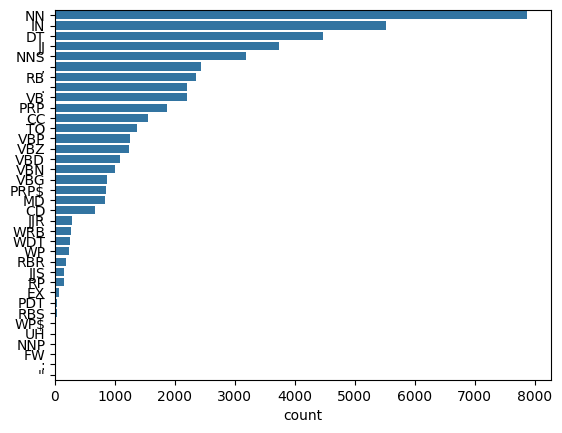

In [60]:
reading_pos_list = plot_pos_tag(reading_corpus)

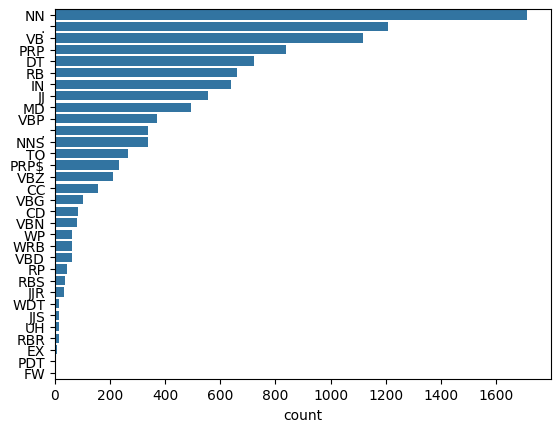

In [61]:
listening_pos_list = plot_pos_tag(listening_corpus)

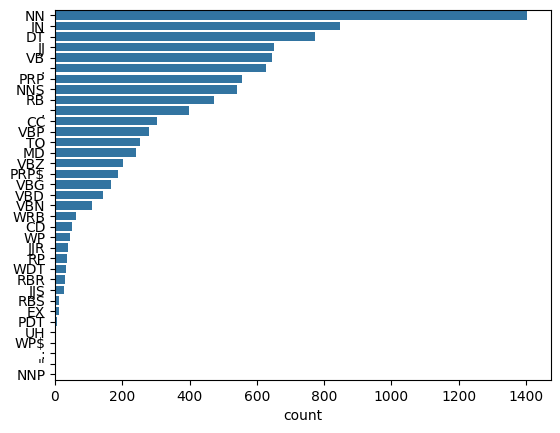

In [62]:
textbook_pos_list = plot_pos_tag(textbook_corpus)

<Axes: xlabel='count'>

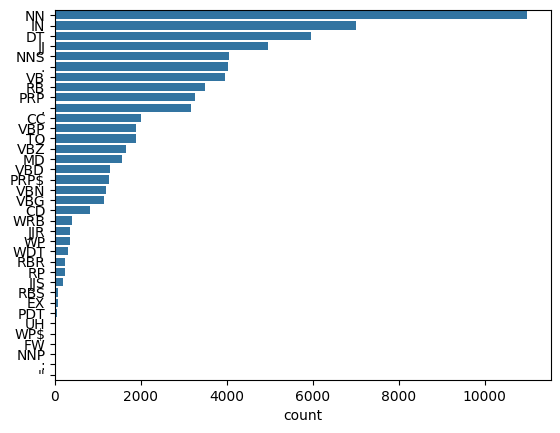

In [63]:
corpus_pos_list = pd.Series(listening_pos_list + reading_pos_list + textbook_pos_list)
sns.countplot(data = corpus_pos_list, order=corpus_pos_list.value_counts().index)

In [74]:
def plot_word_freq(corpus: list):
    # 읽기 지문 품사 분석
    word_list = []   # 품사 정보를 담을 리스트

    for document in corpus: # corpus에서 하나의 json 파일을 가져와서
        document = json_handler.load_data(os.path.join(corpus_path, document))  # 하나의 json 파일 내에 있는 모든 파일을 가져옴.

        if isinstance(document, list):   # 한 json 내에 여러 obj가 있는 경우, 
            for sentence in document:  # json 파일 내 있는 여러 문장들 수 
                word_list.extend(sentence['tokens'])
        else:   # 한 json 내에 하나의 obj가 있는 경우, 
            word_list.extend(document['tokens'])   

    len(word_list)
    #word_list = pd.Series(word_list)
    #sns.countplot(data = word_list, order=word_list.value_counts().index)
    return word_list

In [75]:
listening_word_list = plot_word_freq(listening_corpus)
reading_word_list = plot_word_freq(reading_corpus)
textbook_word_list = plot_word_freq(textbook_corpus)

In [76]:
corpus_word_list = pd.Series(listening_word_list + reading_word_list + textbook_word_list)

In [79]:
corpus_word_list.value_counts()

.             3646
,             3170
the           3149
to            1880
of            1561
              ... 
whatsoever       1
chairs           1
beds             1
double           1
treasured        1
Name: count, Length: 7960, dtype: int64

In [1]:
import contractions
import nltk
from nltk.tokenize import word_tokenize

In [8]:
expanded_text = contractions.fix("I'm running for 2 hours.")
expanded_text


'I am running for 2 hours.'

In [9]:
tokens = word_tokenize(expanded_text)
tokens

['I', 'am', 'running', 'for', '2', 'hours', '.']

In [10]:
nltk.pos_tag(tokens)

[('I', 'PRP'),
 ('am', 'VBP'),
 ('running', 'VBG'),
 ('for', 'IN'),
 ('2', 'CD'),
 ('hours', 'NNS'),
 ('.', '.')]

### **어간 추출(Stemming) 및 표제어 추출(Lemmatization)**
- 두 기법 모두 자연어 처리에서 텍스트 전처리 과정 중에 단어의 원형을 찾는 데 사용.

- 일반적으로 표제어 추출은 어간 추출보다 정교하고 문맥을 잘 이해하는 방식이기 때문에, 자연어 처리에서 더 많이 사용.<br><br>

- **어간 추출** : 단순한 접미사 제거 방식으로 단어의 어간을 추출. 결과는 사전에 있는 단어가 아닐 수 있다.

- **표제어 추출** : 문법적, 의미적으로 올바른 표준 형태의 단어를 추출. 결과는 사전에 등재된 실제 단어.<br><br>

1. **어간 추출 (Stemming)** : 

    - 어간 추출은 단어의 어간(stem)만 남기고 접사(suffix)를 제거하여 단어의 기본 형태를 찾는 과정.

    - 예를 들어, "running", "runs", "runner"는 모두 "run"이라는 어간을 가지고 있다. 따라서 어간 추출은 이들을 모두 "run"으로 축소.

    - 어간 추출은 단순히 규칙 기반의 접미사 제거 방식이기 때문에, 결과로 나오는 단어는 실제 사전에 있는 단어일 필요는 없고, 때로는 일반적이지 않은 형태일 수 있다.<br><br>


2. **표제어 추출 (Lemmatization)** :

    - 표제어 추출은 단어의 표준 형태인 표제어(lemma)를 찾는 과정입니다.

    - 표제어는 사전에 등재된 실제 단어. 예를 들어, "running"의 표제어는 "run", "better"의 표제어는 "good"입니다.

    - 표제어 추출은 단어의 문맥을 고려하고, 형태소 분석(morphological analysis)을 수행하여 단어의 형태와 문법적 의미를 이해한 후에 추출.

    - 따라서 표제어 추출은 언어적, 문법적 규칙을 적용하여 단어를 정규화하는 과정.

### **고민해 봐야할 점**
- **위 두 과정이 필요한가?**

    - 일단 비교 대상이 COCA라면, COCA랑 뭘 비교할 수 있을지 생각해보자.

    - 현재 전처리에서는 동사의 품사 변형 형들에 대한 고려가 되어 있지 않음.
        - e.g. 'running' -> 'VBG' not a 'Verb'
        - 이를 lemmatation 해야할까? 아니면, wordPiece 사용해서 'preprocessing' -> 'pre#' + 'process' + '#ing' 처럼 처리해서 동사별 비교 때 동사의 범위로 봐야할까?
        
    - 축약형들에 대한 조금 더 나은 처리 방법
        - e.g. 'I'm' -> 'I am'으로 잘 되지만, 'Car's' -> 'car s'로 분리된다. 모호하거나 "'s" 에 대한 처리가 조금 더 필요할 듯,,
    

# Corpus merging

In [159]:
import pandas as pd # 데이터 처리
import numpy as np # 데이터 처리
import seaborn as sns # 데이터 시각화
from tqdm import tqdm # 데이터 처리
import re # 정규식으로 특수기호 및 char 처리
import json # 데이터 가공 후 저장할 형식
from typing import Any, Dict, List  # python data-type 정의
from pathlib import Path # 파일 경로 처리
import os # 파일 경로 및 처리

In [160]:
class JsonFileHandler:
    """
    JSON 파일 처리를 담당하는 클래스
    """
    def __init__(self):
        pass
        
    def update_json_file(self, file_path: str, new_data: Any) -> None:
        """
        JSON 파일을 읽고 데이터를 추가한 후 다시 저장
        - 리스트인 경우: id가 동일한 객체가 있으면 덮어씁니다.
        - 리스트가 아닌 경우: id가 다른 객체면 리스트로 변환하여 저장합니다.
        
        Args:
            file_path (str): JSON 파일 경로
            new_data (Any): 추가할 데이터 (id 필드가 있어야 함)
        """
        try:
            # new_data가 딕셔너리이고 id 필드를 포함하는지 확인
            if not isinstance(new_data, dict) or 'id' not in new_data:
                raise ValueError("new_data는 'id' 필드를 포함하는 딕셔너리여야 합니다.")
            
            # 파일 경로 객체 생성
            file_path_obj = Path(file_path)
            
            # 디렉토리가 존재하지 않으면 생성
            file_path_obj.parent.mkdir(parents=True, exist_ok=True)

            # 파일이 존재하는 경우 기존 데이터 읽기
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    existing_data = json.load(f)
            else:
                existing_data = []
            
            # 데이터 추가
            if isinstance(existing_data, list):
                # id가 동일한 객체 찾기
                found = False
                for i, item in enumerate(existing_data):
                    if isinstance(item, dict) and item.get('id') == new_data['id']:
                        existing_data[i] = new_data  # 기존 데이터 덮어쓰기
                        found = True
                        break
                
                # id가 동일한 객체가 없으면 새로 추가
                if not found:
                    existing_data.append(new_data)
                    
            elif isinstance(existing_data, dict):
                # 기존 데이터가 딕셔너리이고 id가 다른 경우
                if existing_data.get('id') != new_data['id']:
                    # 기존 데이터와 새로운 데이터를 리스트로 변환
                    existing_data = [existing_data, new_data]
                else:
                    # id가 같은 경우 덮어쓰기
                    existing_data = new_data
            else:
                # 기존 데이터가 리스트나 딕셔너리가 아닌 경우
                # 새로운 데이터를 리스트로 변환하여 저장
                existing_data = [new_data]
            
            # 데이터 저장
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(existing_data, f, ensure_ascii=False, indent=2)
                
        except json.JSONDecodeError:
            print(f"JSON 파일 형식이 올바르지 않습니다: {file_path}")
        except Exception as e:
            print(f"오류 발생: {str(e)}")
    
    def load_data(self, file_path: str) -> Any:
        """
        JSON 파일에서 데이터 로드
        
        Returns:
            Any: 로드된 데이터
        """
        try:
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    return json.load(f)
            return None
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            return None

In [161]:
files_path = os.path.join(Path.cwd(), 'corpus')
files = [item for item in os.listdir(files_path) if item.endswith('.json')]
files

['textbook_article_다락원 강용순 중등 영어3.json',
 'listening_article_2015_모의.json',
 'reading_article_2008_모의.json',
 'listening_article_2021_수능.json',
 'listening_article_2016_수능.json',
 'reading_article_2007_수능.json',
 'listening_article_2020_모의.json',
 'textbook_article_비상교육 김진환 중등 영어 3.json',
 'reading_article_2011_모의.json',
 'reading_article_2016_수능.json',
 'reading_article_2021_수능.json',
 'textbook_article_비상교육 김진완 고등 영어 독해와 작문.json',
 'listening_article_2007_수능.json',
 'reading_article_2005_모의.json',
 'listening_article_2018_모의.json',
 'reading_article_2024_모의.json',
 'textbook_article_동아출판 박기화 초등 영어5.json',
 'listening_article_2002_수능.json',
 'textbook_article_다락원 김길중 고등 영어1.json',
 'textbook_article_능률NE 김성곤 중등 영어1.json',
 'reading_article_2024_수능.json',
 'reading_article_2013_수능.json',
 'textbook_article_능률NE 양현권 고등 영어 독해와 작문.json',
 'listening_article_2007_모의.json',
 'textbook_article_비상교육 김진완 중등 영어 2.json',
 'listening_article_2013_모의.json',
 'textbook_article_YBM 박준언 고등 영어1.json',

In [162]:
json_handler = JsonFileHandler()
tokens = []
for file_name in tqdm(files, desc='Loading json files'):
    file_path = os.path.join(files_path, file_name)
    data = json_handler.load_data(file_path=file_path)

    if not isinstance(data, list):
        raise ValueError(f"Invalid data type: {type(data)}")

    for sentence in data:
        tokens.extend(sentence['tokens'])

print(len(tokens))

Loading json files: 100%|██████████| 170/170 [00:00<00:00, 2803.75it/s]

67871


In [170]:
df = pd.Series(tokens).value_counts()
df.to_csv('././corpus/frequency.csv', index=True)

In [172]:
df = pd.DataFrame({
    'Word': df.index,
    'Freq_CSAT': df.values,
    'LogE_Freq_CSAT': np.log(df.values), # base e=2.718
    'Log10_Freq_CSAT': np.log10(df.values + 1)
})
df

,Word,Freq_CSAT,LogE_Freq_CSAT,Log10_Freq_CSAT
0,.,3646,8.201386,3.561936
1,",",3170,8.061487,3.501196
2,the,3149,8.054840,3.498311
3,to,1880,7.539027,3.274389
4,of,1561,7.353082,3.193681
...,...,...,...,...
7955,packaging,1,0.000000,0.301030
7956,leftover,1,0.000000,0.301030
7957,adopted,1,0.000000,0.301030
7958,unprofitable,1,0.000000,0.301030


In [173]:
target_df = pd.read_csv('././target_corpora/English Lexicon Project Items.csv')
target_df.head()

,Word,Length,Freq_HAL,Log_Freq_HAL,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,OLDF
0,a,1,"10,610,626",16.177,"20,415.270",6.018,1,1.450,9.831
1,aah,3,222,5.403,52.710,3.430,2,1.850,9.105
2,Aaron,5,"10,806",9.288,14.650,2.874,3,1.850,7.315
3,aback,5,387,5.958,0.290,1.204,0,1.950,7.737
4,abacus,6,513,6.240,0.240,1.114,0,2.900,7.391


In [174]:
target_df.shape

(40481, 9)

In [175]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          40480 non-null  object 
 1   Length        40481 non-null  int64  
 2   Freq_HAL      40481 non-null  object 
 3   Log_Freq_HAL  40481 non-null  float64
 4   SUBTLWF       40481 non-null  object 
 5   LgSUBTLWF     40481 non-null  object 
 6   Ortho_N       40481 non-null  int64  
 7   OLD           40481 non-null  object 
 8   OLDF          40481 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 2.8+ MB


In [176]:
df = pd.merge(df, target_df, how='inner', on='Word')
df

,Word,Freq_CSAT,LogE_Freq_CSAT,Log10_Freq_CSAT,Length,Freq_HAL,Log_Freq_HAL,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,OLDF
0,the,3149,8.054840,3.498311,3,"23,099,033",16.955,"29,449.180",6.177,5,1.500,9.170
1,to,1880,7.539027,3.274389,2,"12,661,276",16.354,"22,677.840",6.063,7,1.150,9.580
2,of,1561,7.353082,3.193681,2,"11,003,606",16.214,"11,577.240",5.771,8,1.450,9.704
3,and,1493,7.308543,3.174351,3,"10,715,411",16.187,"13,387.840",5.834,6,1.250,9.101
4,a,1272,7.148346,3.104828,1,"10,610,626",16.177,"20,415.270",6.018,1,1.450,9.831
...,...,...,...,...,...,...,...,...,...,...,...,...
6584,missions,1,0.000000,0.301030,8,"6,941",8.845,2.880,2.170,0,2.200,7.312
6585,thick,1,0.000000,0.301030,5,"11,429",9.344,13.980,2.854,3,1.750,8.487
6586,packaging,1,0.000000,0.301030,9,"5,910",8.684,0.840,1.643,0,2.950,6.890
6587,adopted,1,0.000000,0.301030,7,"9,446",9.153,8.430,2.635,1,2.450,6.387


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Word           6589 non-null   object 
 1   Freq_CSAT      6589 non-null   int64  
 2   Log_Freq_CSAT  6589 non-null   float64
 3   Length         6589 non-null   int64  
 4   Freq_HAL       6589 non-null   object 
 5   Log_Freq_HAL   6589 non-null   float64
 6   SUBTLWF        6589 non-null   object 
 7   LgSUBTLWF      6589 non-null   object 
 8   Ortho_N        6589 non-null   int64  
 9   OLD            6589 non-null   object 
 10  OLDF           6589 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 566.4+ KB


# Data cleaning

In [137]:
(20415.270)**(1/6.018)

5.2020835456470005

In [138]:
(52.710)**(1/3.430)

3.176944483782197

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             6589 non-null   object 
 1   Freq_CSAT        6589 non-null   int64  
 2   LogE_Freq_CSAT   6589 non-null   float64
 3   Log10_Freq_CSAT  6589 non-null   float64
 4   Length           6589 non-null   int64  
 5   Freq_HAL         6589 non-null   object 
 6   Log_Freq_HAL     6589 non-null   float64
 7   SUBTLWF          6589 non-null   object 
 8   LgSUBTLWF        6589 non-null   object 
 9   Ortho_N          6589 non-null   int64  
 10  OLD              6589 non-null   object 
 11  OLDF             6589 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 617.8+ KB


In [186]:
class TargetCorpusPreprocessor:
    """
    Change the data type:
        Word: object(keep)

        Freq_CSAT : int (keep)
        LogE_Freq_CSAT : float(keep) (log base: e)
        Log10_Freq_CSAT : float(keep) (log base: 10 with bias 1) : log_10_(value+1)

        Length : int64(keep)

        Freq_HAL : object -> int (remove comma)
        Log_Freq_HAL : object -> float (log base: e)

        SUBTLWF : object -> float (remove comma, freq per million)
        LgSUBTLWF : object -> float / log10(number of times the word appears in the corpus + 1)
        
        Ortho_N : int64 -> int64 (keep)
        OLD : object -> float
        OLDF : object -> float
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.col_name = df.columns
    
    
    def remove_hash(self, col_name: str) -> pd.DataFrame:
        for idx, value in enumerate(self.df[col_name]):
            if '#' in value:
                self.df.loc[idx, col_name] = None
        return self.df

    def remove_comma(self, col_name: str) -> pd.DataFrame:
        self.df[col_name] = self.df[col_name].str.replace(',', '')
        return self.df
    
    def change_col_type(self, col_name: str, dtype: str) -> pd.DataFrame:
        self.df[col_name] = self.df[col_name].astype(dtype)
        return self.df


    def preprocess(self) -> pd.DataFrame:

        for col_name in tqdm(self.col_name, desc='Cleaning information col by col'):
            if self.df[col_name].dtype == 'object' and not col_name in ['Word']:
                print(col_name)
                self.df = self.remove_hash(col_name)
                self.df = self.remove_comma(col_name)
        
        #self.df.dropna(inplace=True)
        
        # change column data type
        self.df = self.change_col_type('Freq_HAL', 'int64')
        #self.df = self.change_col_type('Log_Freq_HAL', 'float')
        self.df = self.change_col_type('SUBTLWF', 'float')
        self.df = self.change_col_type('LgSUBTLWF', 'float')
        self.df = self.change_col_type('OLD', 'float')
        self.df = self.change_col_type('OLDF', 'float')
            
        return self.df

In [187]:
new_df = TargetCorpusPreprocessor(df).preprocess()
new_df

Cleaning information col by col: 100%|██████████| 12/12 [00:00<00:00, 200.06it/s]

Freq_HAL
SUBTLWF
LgSUBTLWF
OLD
OLDF


,Word,Freq_CSAT,LogE_Freq_CSAT,Log10_Freq_CSAT,Length,Freq_HAL,Log_Freq_HAL,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,OLDF
0,the,3149,8.054840,3.498311,3,23099033,16.955,29449.18,6.177,5,1.50,9.170
1,to,1880,7.539027,3.274389,2,12661276,16.354,22677.84,6.063,7,1.15,9.580
2,of,1561,7.353082,3.193681,2,11003606,16.214,11577.24,5.771,8,1.45,9.704
3,and,1493,7.308543,3.174351,3,10715411,16.187,13387.84,5.834,6,1.25,9.101
4,a,1272,7.148346,3.104828,1,10610626,16.177,20415.27,6.018,1,1.45,9.831
...,...,...,...,...,...,...,...,...,...,...,...,...
6584,missions,1,0.000000,0.301030,8,6941,8.845,2.88,2.170,0,2.20,7.312
6585,thick,1,0.000000,0.301030,5,11429,9.344,13.98,2.854,3,1.75,8.487
6586,packaging,1,0.000000,0.301030,9,5910,8.684,0.84,1.643,0,2.95,6.890
6587,adopted,1,0.000000,0.301030,7,9446,9.153,8.43,2.635,1,2.45,6.387


In [188]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             6589 non-null   object 
 1   Freq_CSAT        6589 non-null   int64  
 2   LogE_Freq_CSAT   6589 non-null   float64
 3   Log10_Freq_CSAT  6589 non-null   float64
 4   Length           6589 non-null   int64  
 5   Freq_HAL         6589 non-null   int64  
 6   Log_Freq_HAL     6589 non-null   float64
 7   SUBTLWF          6568 non-null   float64
 8   LgSUBTLWF        6568 non-null   float64
 9   Ortho_N          6589 non-null   int64  
 10  OLD              6589 non-null   float64
 11  OLDF             6589 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 617.8+ KB


In [189]:
new_df.to_csv('./corpus/merged_corpus.csv', index=False)

# Visualize and Analyze

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

class FrequencyCorrelationAnalyzer:
    def __init__(self, df, col1, col2, normalize: bool = False, bins: np.ndarray = None):
        """
        단어 빈도수 컬럼 간 상관관계 분석 클래스
        
        Parameters:
        df: pandas DataFrame
        col1: 첫 번째 빈도수 컬럼명
        col2: 두 번째 빈도수 컬럼명
        """
        self.df = df.copy()
        self.col1 = col1
        self.col2 = col2
        self.normalize = normalize
        self.bins = bins

        if self.normalize:
            self.scaler = {
                'col1': StandardScaler(),
                'col2': StandardScaler()
            }
        
        # 결측값 제거
        self.df_clean = self.df[[col1, col2]].dropna()
    
    def normalize_col(self):
        self.df_clean[self.col1] = self.scaler['col1'].fit_transform(self.df_clean[self.col1].values.reshape(-1, 1))
        self.df_clean[self.col2] = self.scaler['col2'].fit_transform(self.df_clean[self.col2].values.reshape(-1, 1))
        
    def calculate_correlation(self):
        """상관계수 계산"""
        # 피어슨 상관계수 (선형 관계)
        pearson_corr, pearson_p = stats.pearsonr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 스피어만 상관계수 (순위 관계)
        spearman_corr, spearman_p = stats.spearmanr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 켄달 타우 (순위 관계)
        kendall_corr, kendall_p = stats.kendalltau(self.df_clean[self.col1], self.df_clean[self.col2])
        
        return {
            'pearson': {'correlation': pearson_corr, 'p_value': pearson_p},
            'spearman': {'correlation': spearman_corr, 'p_value': spearman_p},
            'kendall': {'correlation': kendall_corr, 'p_value': kendall_p}
        }
    
    def plot_scatter(self, figsize=(10, 8)):
        """산점도 그리기"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # 원본 데이터 산점도
        ax1.scatter(self.df_clean[self.col1], self.df_clean[self.col2], alpha=0.6)
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel(self.col2)
        ax1.set_title(f'{self.col1} vs {self.col2} (원본 데이터)')
        ax1.grid(True, alpha=0.3)
        
        # 로그 변환된 데이터 산점도 (빈도수 데이터에 유용)
        log_col1 = np.log1p(self.df_clean[self.col1])  # log(1+x) 변환
        log_col2 = np.log1p(self.df_clean[self.col2])
        
        ax2.scatter(log_col1, log_col2, alpha=0.6, color='orange')
        ax2.set_xlabel(f'log(1 + {self.col1})')
        ax2.set_ylabel(f'log(1 + {self.col2})')
        ax2.set_title(f'{self.col1} vs {self.col2} (로그 변환)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_heatmap(self, figsize=(8, 6)):
        """상관계수 히트맵"""
        corr_matrix = self.df_clean.corr()
        
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.3f')
        plt.title('상관계수 히트맵')
        plt.show()
    
    def plot_distribution(self, figsize=(12, 5)):
        """분포 시각화"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        # 현재 그리는 분포는 규모가 서로 다르므로, 다른 bin 값을 적용할 필요가 있음.
        if not self.normalize and self.bins is None:
            bins = 30
        elif self.normalize and self.bins is None:
            bins = np.arange(-1.5, 1.5, 0.1)
        else:
            bins = self.bins

        # 첫 번째 컬럼 분포
        ax1.hist(self.df_clean[self.col1], bins=bins, alpha=0.7, color='skyblue')
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel('빈도')
        ax1.set_title(f'{self.col1} 분포')
        ax1.grid(True, alpha=0.3)
        
        # 두 번째 컬럼 분포
        ax2.hist(self.df_clean[self.col2], bins=bins, alpha=0.7, color='lightcoral')
        ax2.set_xlabel(self.col2)
        ax2.set_ylabel('빈도')
        ax2.set_title(f'{self.col2} 분포')
        ax2.grid(True, alpha=0.3)
        
        # 박스플롯
        ax3.boxplot([self.df_clean[self.col1], self.df_clean[self.col2]], 
                   labels=[self.col1, self.col2])
        ax3.set_ylabel('빈도수')
        ax3.set_title('박스플롯 비교')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """분석 결과 요약 출력"""
        print("=" * 60)
        print("단어 빈도수 상관관계 분석 결과")
        print("=" * 60)
        
        # 기본 통계
        print(f"\n📊 기본 통계:")
        print(f"데이터 개수: {len(self.df_clean)}")
        print(f"{self.col1} - 평균: {self.df_clean[self.col1].mean():.2f}, 표준편차: {self.df_clean[self.col1].std():.2f}")
        print(f"{self.col2} - 평균: {self.df_clean[self.col2].mean():.2f}, 표준편차: {self.df_clean[self.col2].std():.2f}")
        
        # 상관계수
        corr_results = self.calculate_correlation()
        
        print(f"\n🔗 상관계수:")
        print(f"피어슨 상관계수: {corr_results['pearson']['correlation']:.4f} (p-value: {corr_results['pearson']['p_value']:.4f})")
        print(f"스피어만 상관계수: {corr_results['spearman']['correlation']:.4f} (p-value: {corr_results['spearman']['p_value']:.4f})")
        print(f"켄달 타우: {corr_results['kendall']['correlation']:.4f} (p-value: {corr_results['kendall']['p_value']:.4f})")
        
        # 해석
        print(f"\n📝 해석:")
        pearson_corr = corr_results['pearson']['correlation']
        pearson_p = corr_results['pearson']['p_value']
        
        if pearson_p < 0.001:
            significance = "매우 유의함 (p < 0.001)"
        elif pearson_p < 0.01:
            significance = "매우 유의함 (p < 0.01)"
        elif pearson_p < 0.05:
            significance = "유의함 (p < 0.05)"
        else:
            significance = "유의하지 않음 (p >= 0.05)"
        
        print(f"통계적 유의성: {significance}")
        
        if abs(pearson_corr) >= 0.8:
            strength = "매우 강한"
        elif abs(pearson_corr) >= 0.6:
            strength = "강한"
        elif abs(pearson_corr) >= 0.4:
            strength = "중간 정도의"
        elif abs(pearson_corr) >= 0.2:
            strength = "약한"
        else:
            strength = "매우 약한"
        
        direction = "양의" if pearson_corr > 0 else "음의"
        print(f"상관관계 강도: {strength} {direction} 상관관계")
        
        print("=" * 60)
    
    def run_full_analysis(self):
        """전체 분석 실행"""
        if self.normalize:
            self.normalize_col()
        self.print_summary()
        self.plot_scatter()
        self.plot_heatmap()
        self.plot_distribution()

# 사용 예시 함수
def analyze_word_frequency_correlation(df: pd.DataFrame, col1: str, col2: str, normalize: bool = False, bins: np.ndarray = None):
    """
    단어 빈도수 컬럼 간 상관관계 분석을 실행하는 편의 함수
    
    Parameters:
    df: pandas DataFrame
    col1: 첫 번째 빈도수 컬럼명
    col2: 두 번째 빈도수 컬럼명
    normalize: 정규화 여부
    bins: 분포 시각화 시 사용할 bin 값
    """
    analyzer = FrequencyCorrelationAnalyzer(df, col1, col2, normalize, bins)
    analyzer.run_full_analysis()
    return analyzer

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             6589 non-null   object 
 1   Freq_CSAT        6589 non-null   int64  
 2   LogE_Freq_CSAT   6589 non-null   float64
 3   Log10_Freq_CSAT  6589 non-null   float64
 4   Length           6589 non-null   int64  
 5   Freq_HAL         6589 non-null   object 
 6   Log_Freq_HAL     6589 non-null   float64
 7   SUBTLWF          6589 non-null   object 
 8   LgSUBTLWF        6589 non-null   object 
 9   Ortho_N          6589 non-null   int64  
 10  OLD              6589 non-null   object 
 11  OLDF             6589 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 617.8+ KB


## Normalize 전

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6568
SUBTLWF - 평균: 0.00, 표준편차: 1.00
Freq_HAL - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8178 (p-value: 0.0000)
스피어만 상관계수: 0.8060 (p-value: 0.0000)
켄달 타우: 0.6156 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


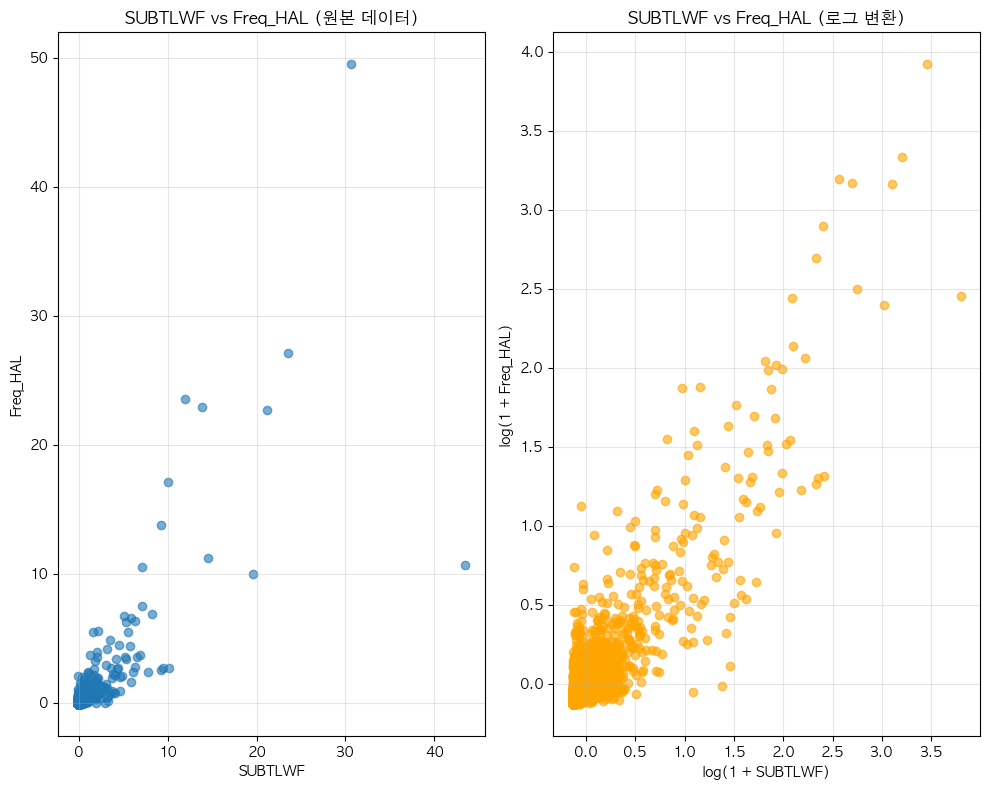

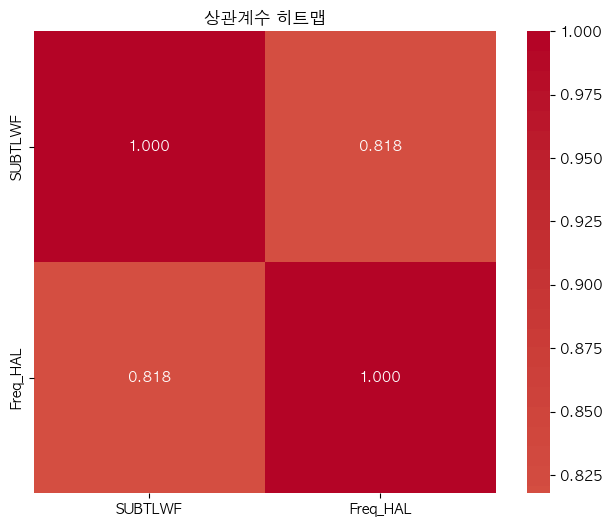

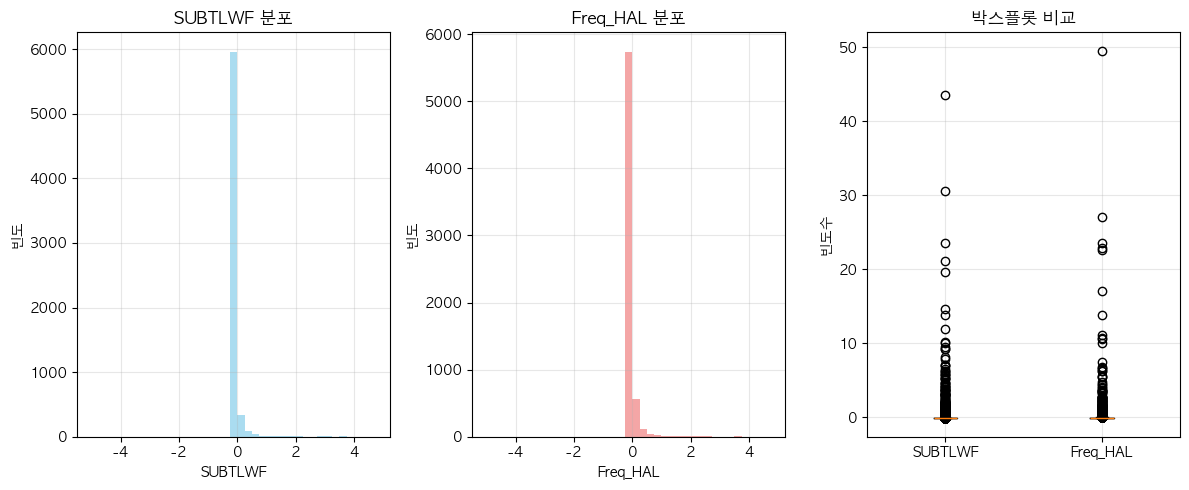

In [331]:
analyzer = analyze_word_frequency_correlation(new_df, 'SUBTLWF', 'Freq_HAL', normalize=True, bins=np.arange(-5, 5, 0.25))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
Freq_CSAT - 평균: 8.72, 표준편차: 65.02
Freq_HAL - 평균: 55931.08, 표준편차: 464917.02

🔗 상관계수:
피어슨 상관계수: 0.9854 (p-value: 0.0000)
스피어만 상관계수: 0.6901 (p-value: 0.0000)
켄달 타우: 0.5484 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


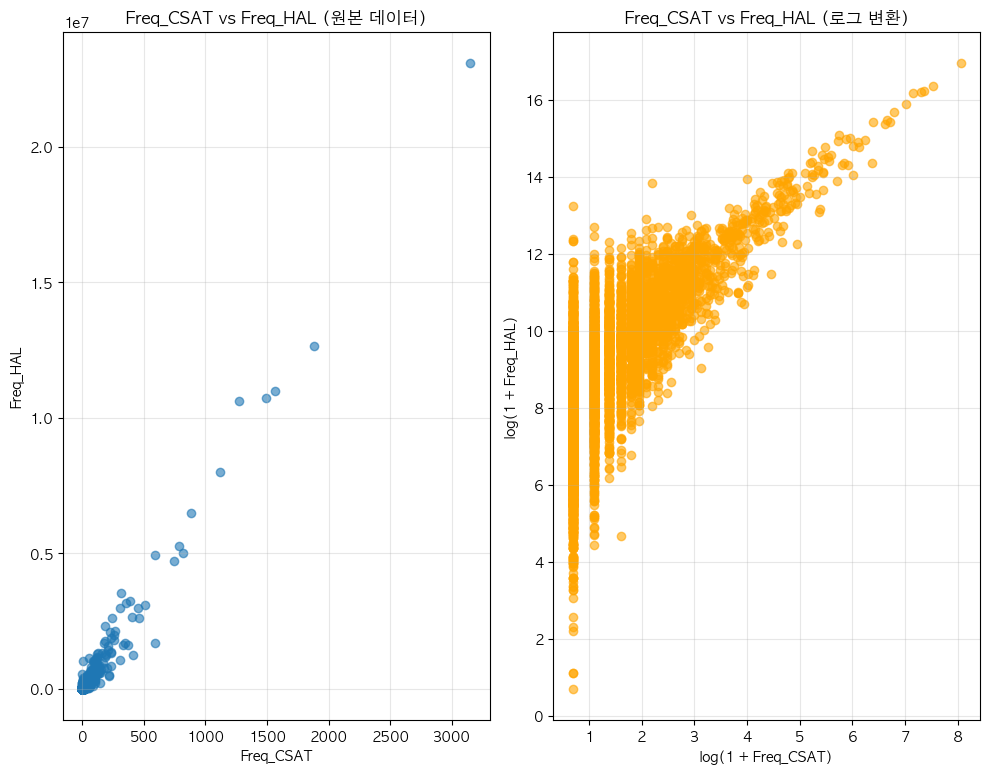

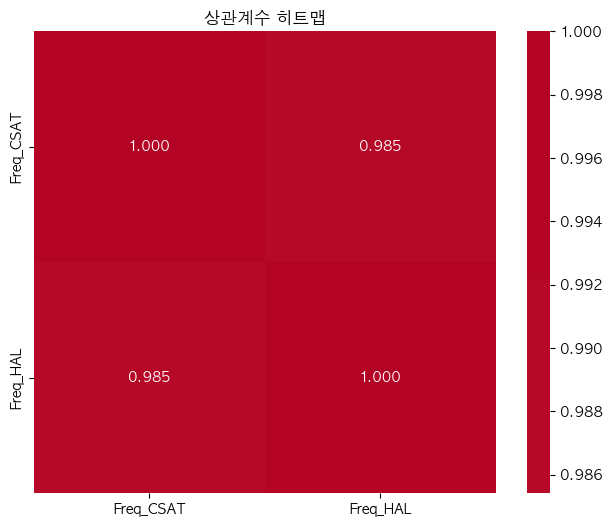

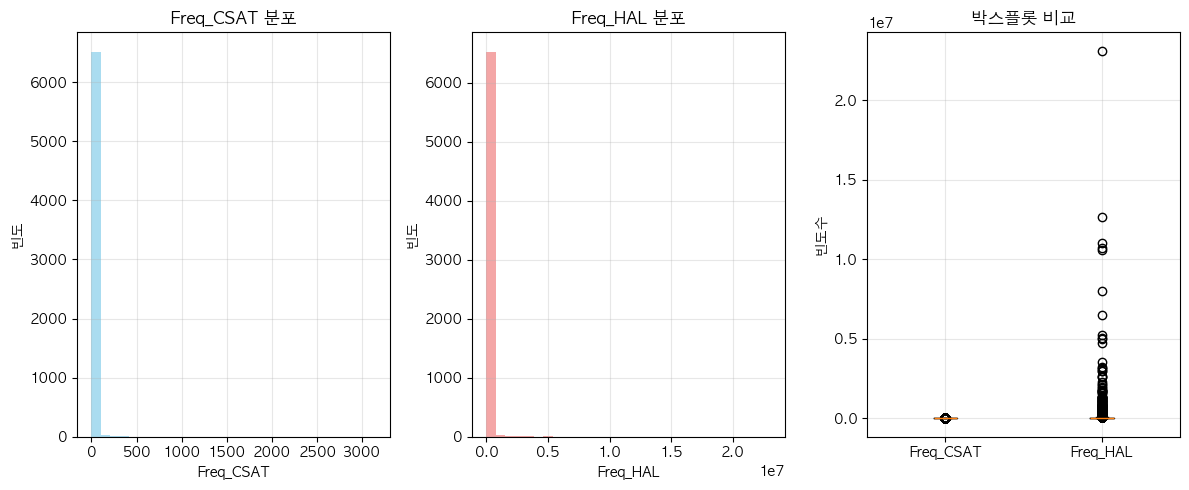

In [244]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT', 'Freq_HAL', normalize=False)

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
LogE_Freq_CSAT - 평균: 0.88, 표준편차: 1.10
Log_Freq_HAL - 평균: 8.96, 표준편차: 1.79

🔗 상관계수:
피어슨 상관계수: 0.7316 (p-value: 0.0000)
스피어만 상관계수: 0.6901 (p-value: 0.0000)
켄달 타우: 0.5484 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


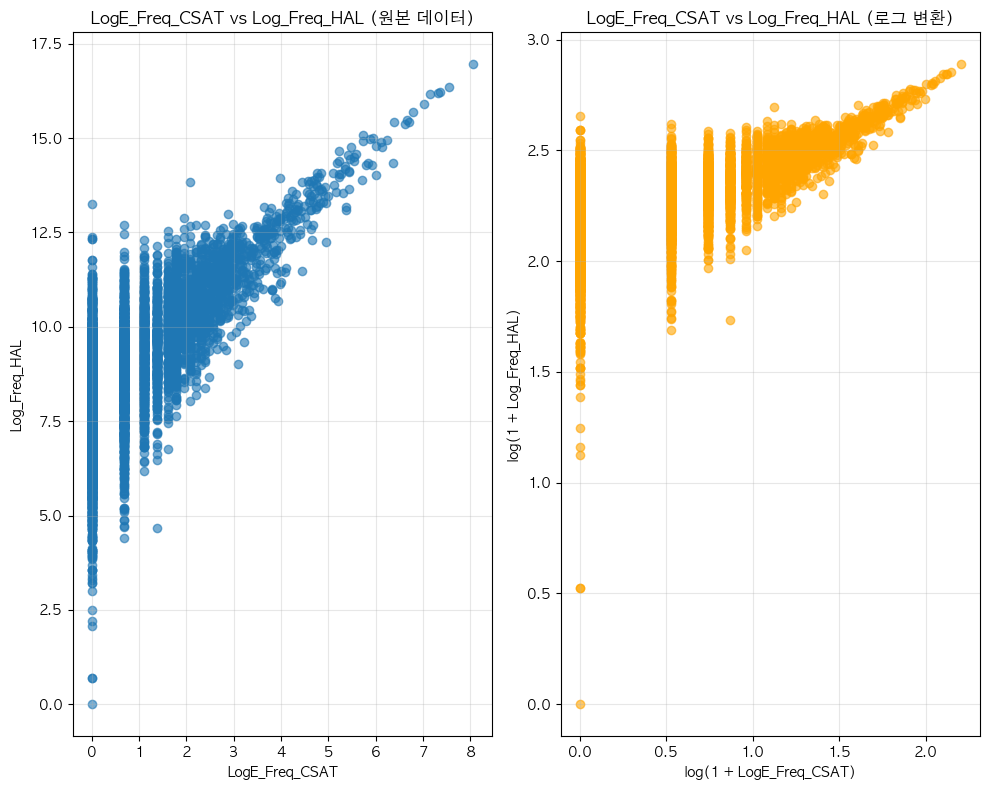

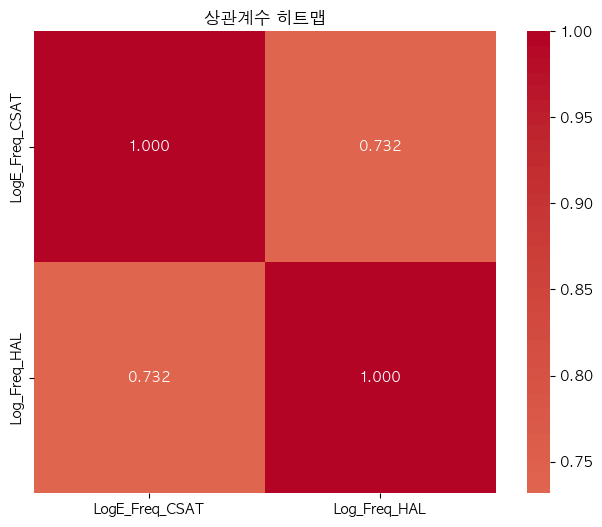

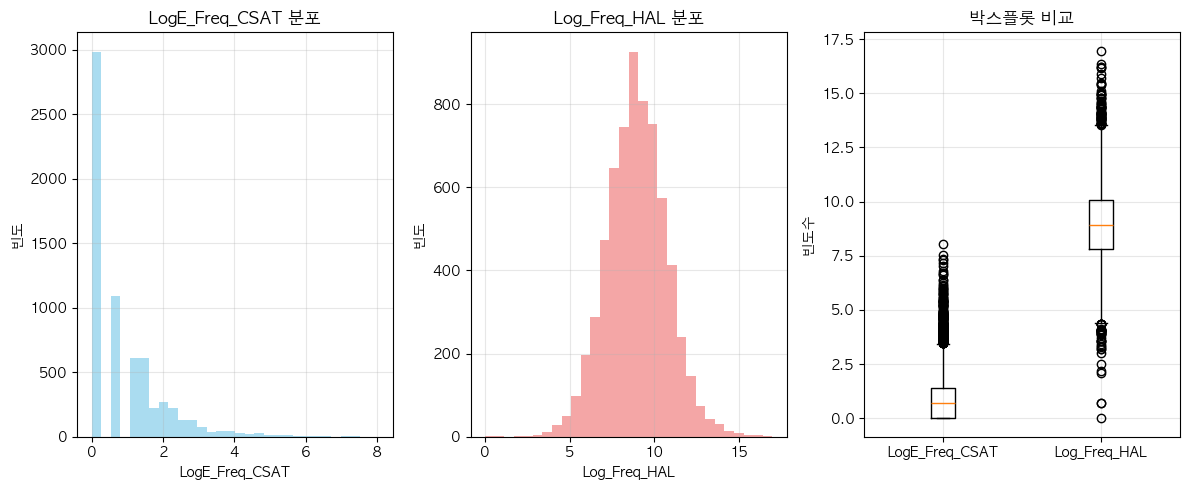

In [235]:
analyzer = analyze_word_frequency_correlation(new_df, 'LogE_Freq_CSAT', 'Log_Freq_HAL', normalize=False)

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6568
Freq_CSAT - 평균: 8.74, 표준편차: 65.12
SUBTLWF - 평균: 117.83, 표준편차: 959.70

🔗 상관계수:
피어슨 상관계수: 0.8258 (p-value: 0.0000)
스피어만 상관계수: 0.6056 (p-value: 0.0000)
켄달 타우: 0.4702 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


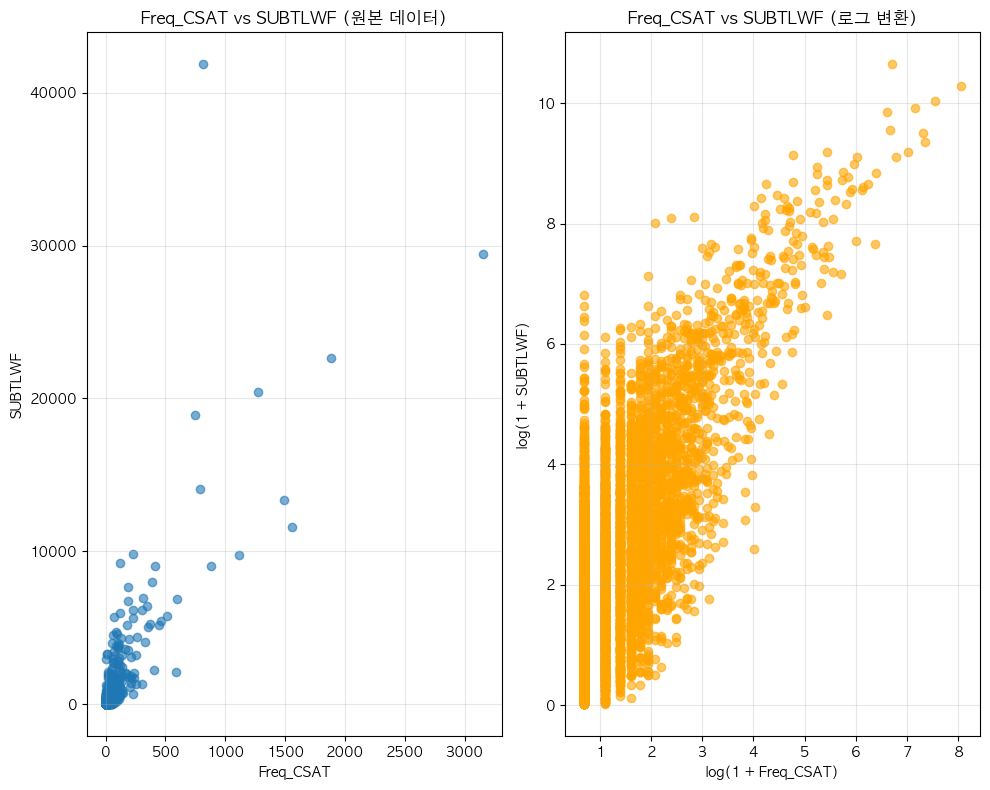

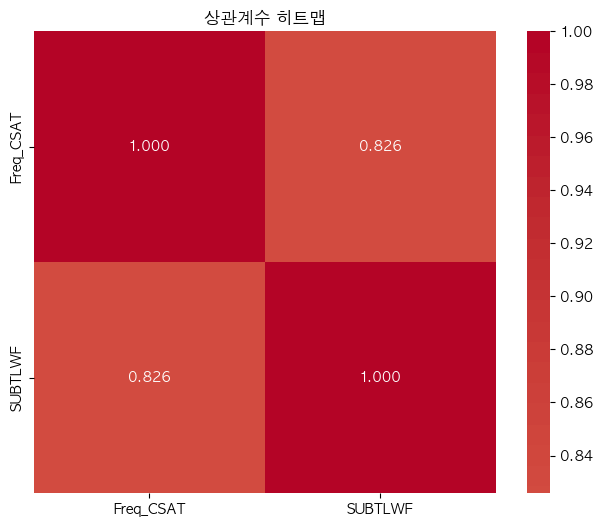

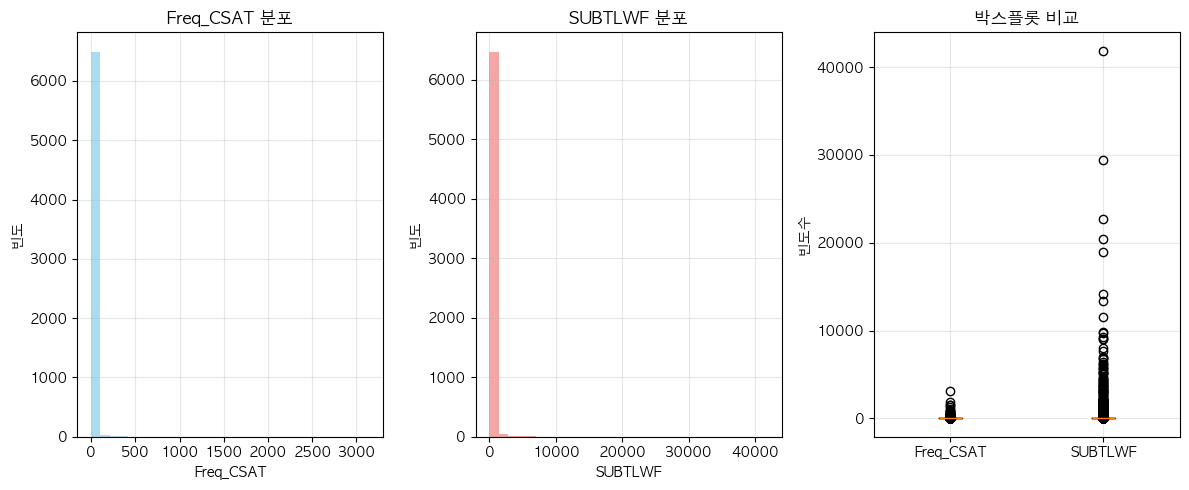

In [236]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT', 'SUBTLWF', normalize=False)

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6568
Log10_Freq_CSAT - 평균: 0.57, 표준편차: 0.38
LgSUBTLWF - 평균: 2.59, 표준편차: 0.89

🔗 상관계수:
피어슨 상관계수: 0.6872 (p-value: 0.0000)
스피어만 상관계수: 0.6055 (p-value: 0.0000)
켄달 타우: 0.4702 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


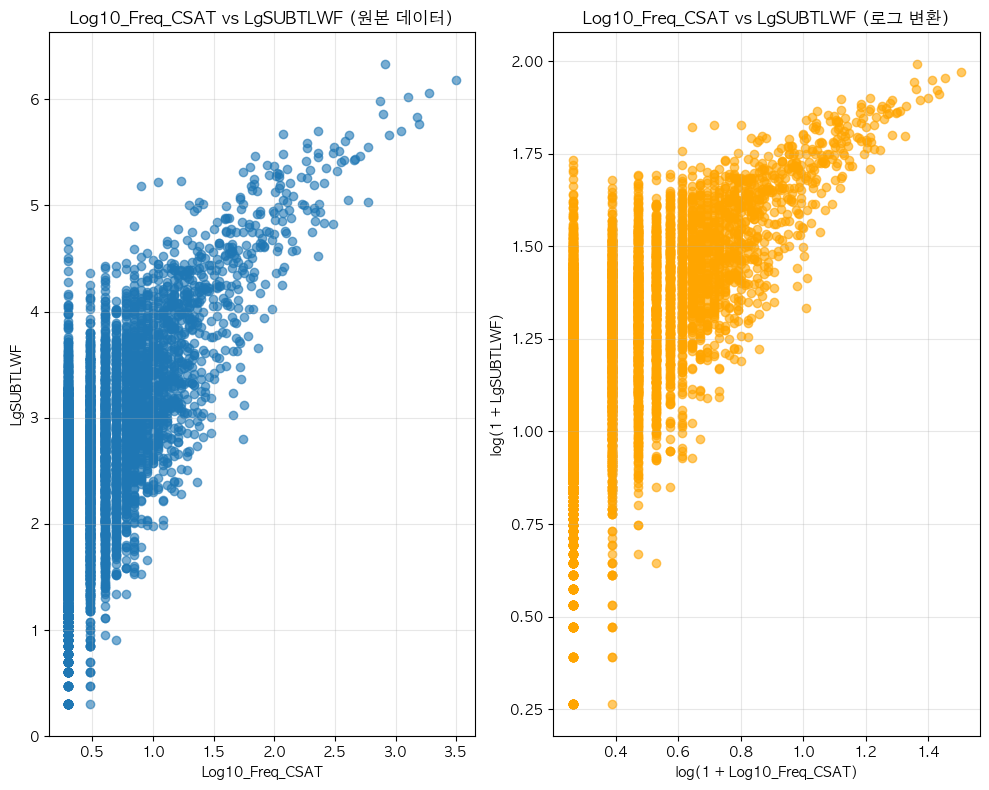

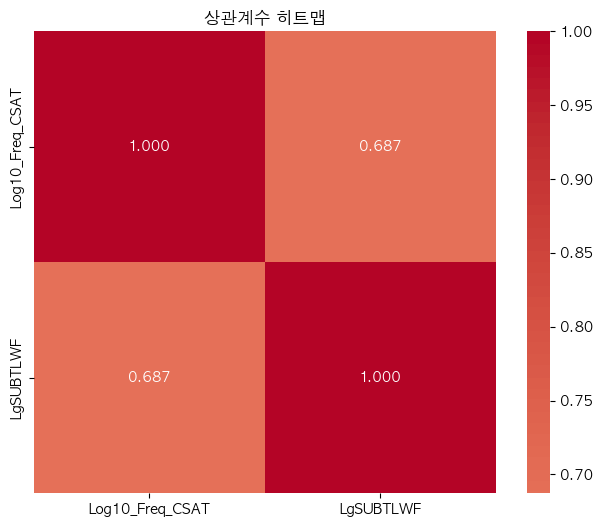

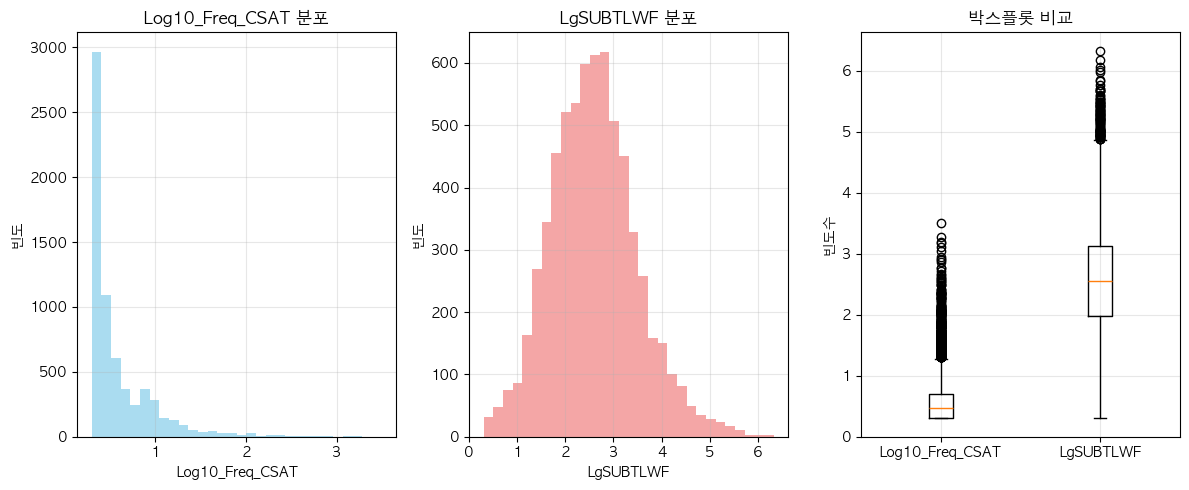

In [237]:
analyzer = analyze_word_frequency_correlation(new_df, 'Log10_Freq_CSAT', 'LgSUBTLWF', normalize=False)

## Normalize 후

In [272]:
new_df

,Word,Freq_CSAT,LogE_Freq_CSAT,Log10_Freq_CSAT,Length,Freq_HAL,Log_Freq_HAL,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,OLDF
0,the,3149,8.054840,3.498311,3,23099033,16.955,29449.18,6.177,5,1.50,9.170
1,to,1880,7.539027,3.274389,2,12661276,16.354,22677.84,6.063,7,1.15,9.580
2,of,1561,7.353082,3.193681,2,11003606,16.214,11577.24,5.771,8,1.45,9.704
3,and,1493,7.308543,3.174351,3,10715411,16.187,13387.84,5.834,6,1.25,9.101
4,a,1272,7.148346,3.104828,1,10610626,16.177,20415.27,6.018,1,1.45,9.831
...,...,...,...,...,...,...,...,...,...,...,...,...
6584,missions,1,0.000000,0.301030,8,6941,8.845,2.88,2.170,0,2.20,7.312
6585,thick,1,0.000000,0.301030,5,11429,9.344,13.98,2.854,3,1.75,8.487
6586,packaging,1,0.000000,0.301030,9,5910,8.684,0.84,1.643,0,2.95,6.890
6587,adopted,1,0.000000,0.301030,7,9446,9.153,8.43,2.635,1,2.45,6.387


단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6568
SUBTLWF - 평균: 0.00, 표준편차: 1.00
Freq_HAL - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8178 (p-value: 0.0000)
스피어만 상관계수: 0.8060 (p-value: 0.0000)
켄달 타우: 0.6156 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


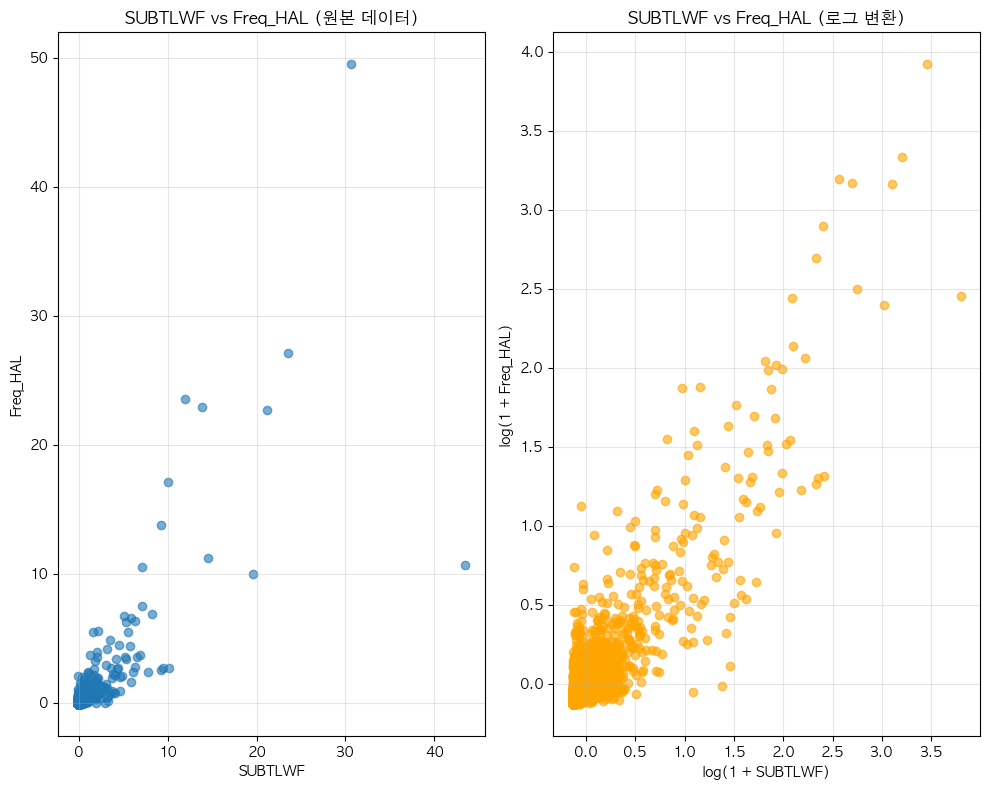

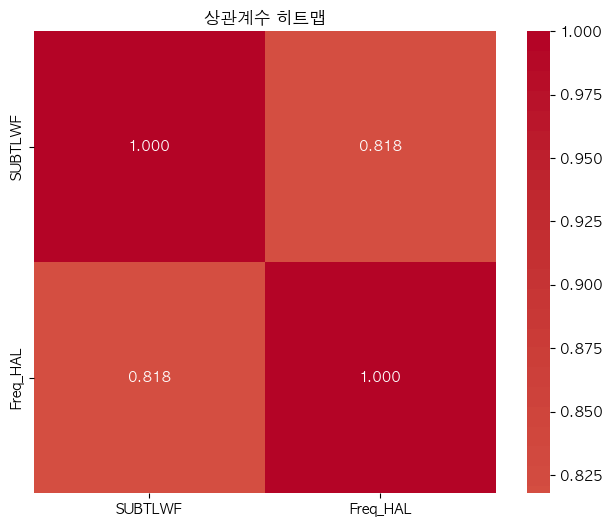

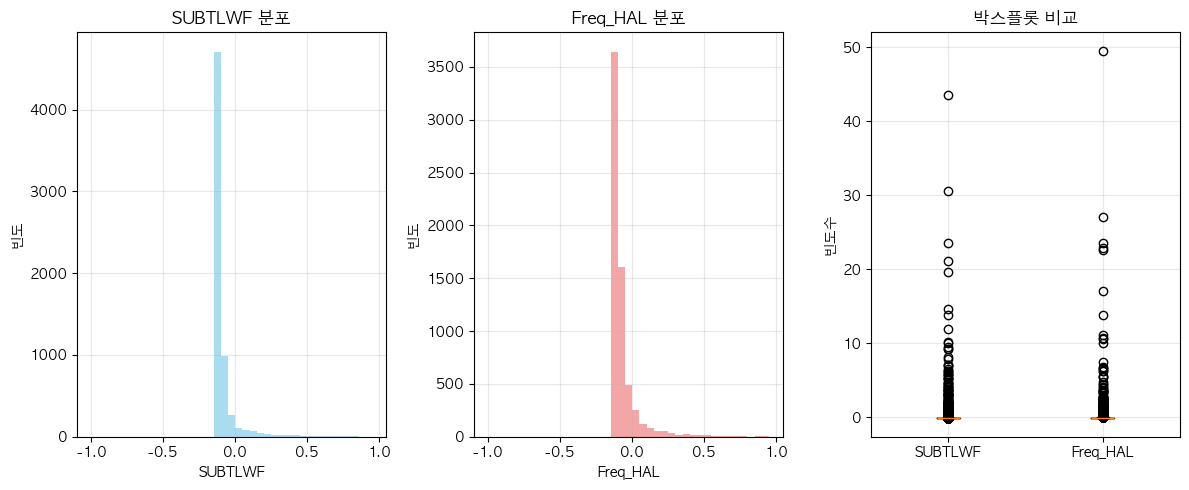

In [273]:
analyzer = analyze_word_frequency_correlation(new_df, 'SUBTLWF', 'Freq_HAL', normalize=True, bins=np.arange(-1, 1, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
Freq_CSAT - 평균: -0.00, 표준편차: 1.00
Freq_HAL - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9854 (p-value: 0.0000)
스피어만 상관계수: 0.6901 (p-value: 0.0000)
켄달 타우: 0.5484 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


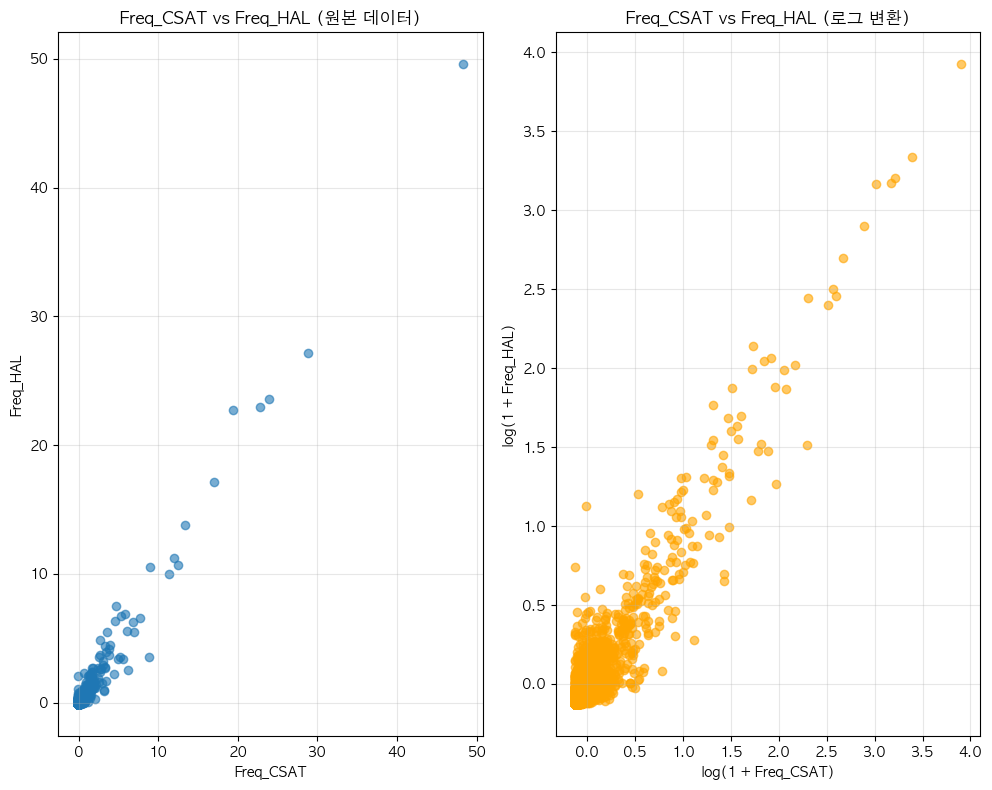

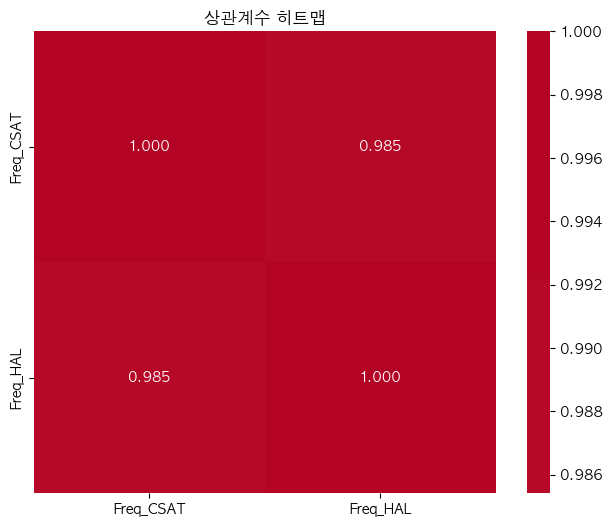

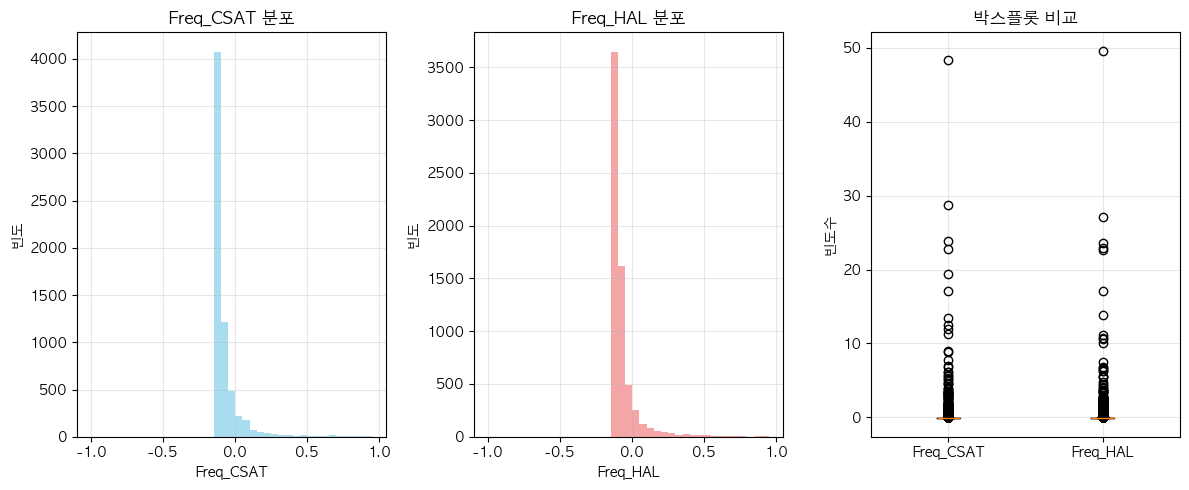

In [265]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT', 'Freq_HAL', normalize=True, bins=np.arange(-1, 1, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
LogE_Freq_CSAT - 평균: 0.00, 표준편차: 1.00
Log_Freq_HAL - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.7316 (p-value: 0.0000)
스피어만 상관계수: 0.6901 (p-value: 0.0000)
켄달 타우: 0.5484 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


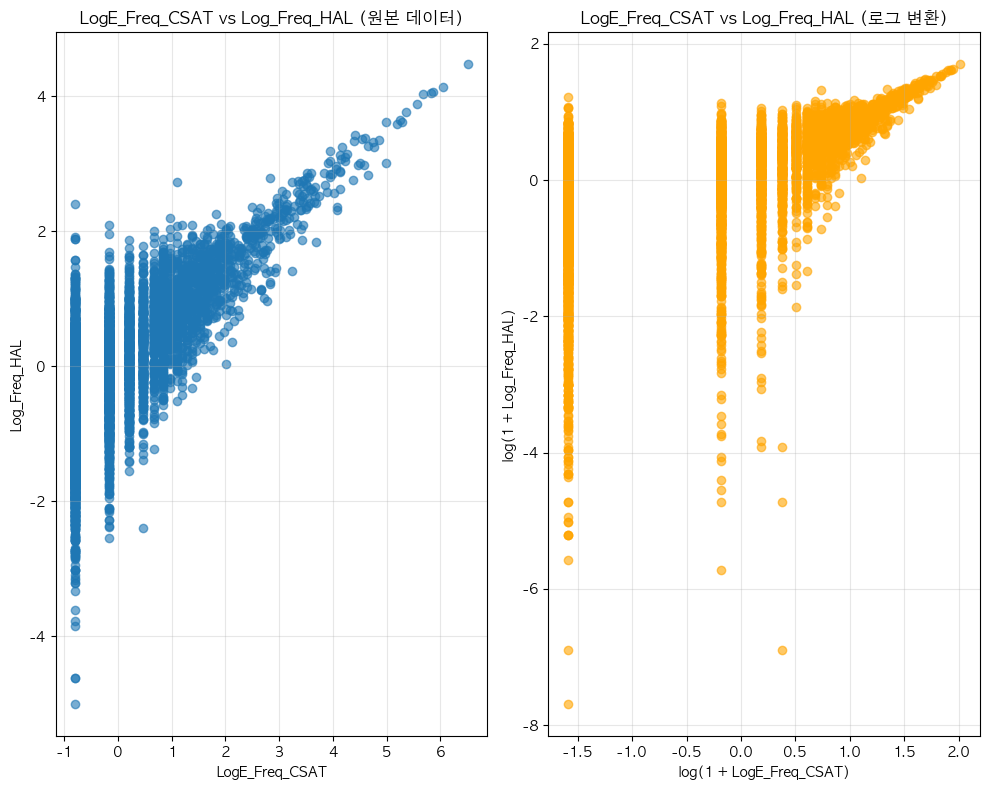

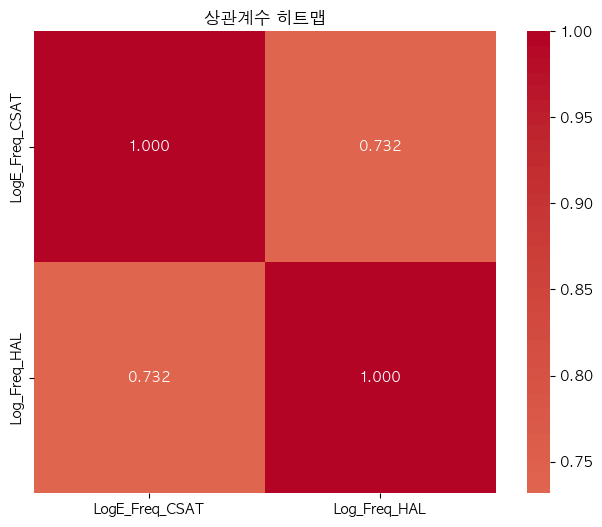

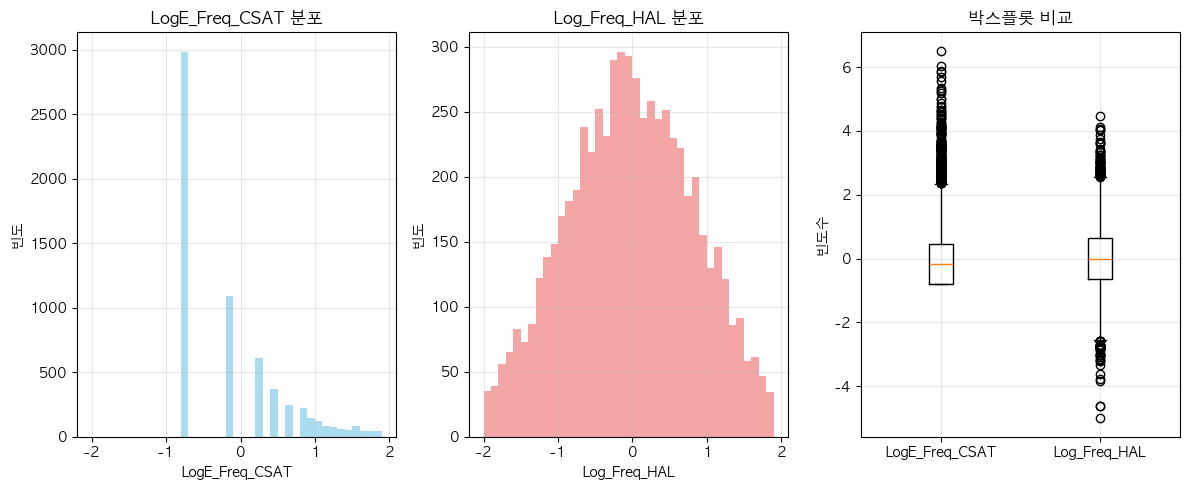

In [267]:
analyzer = analyze_word_frequency_correlation(new_df, 'LogE_Freq_CSAT', 'Log_Freq_HAL', normalize=True, bins=np.arange(-2, 2, 0.1))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6568
Freq_CSAT - 평균: 0.00, 표준편차: 1.00
SUBTLWF - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8258 (p-value: 0.0000)
스피어만 상관계수: 0.6056 (p-value: 0.0000)
켄달 타우: 0.4702 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


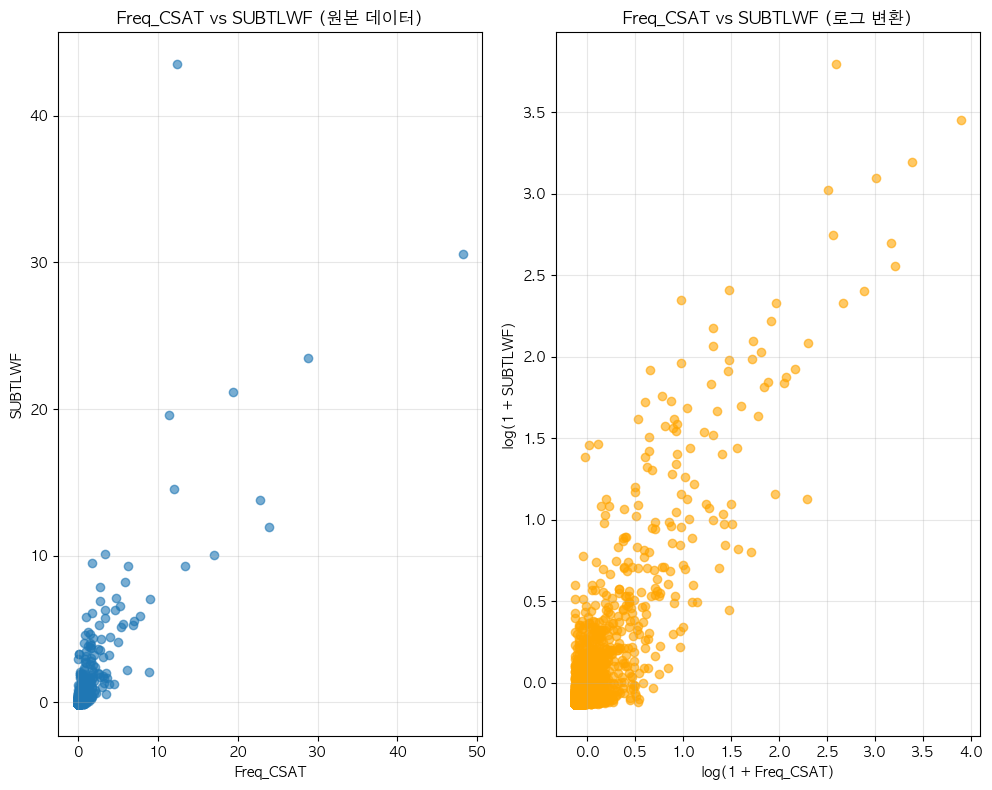

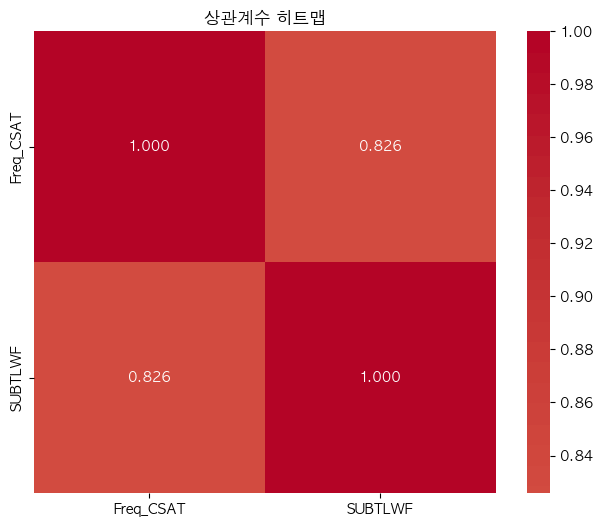

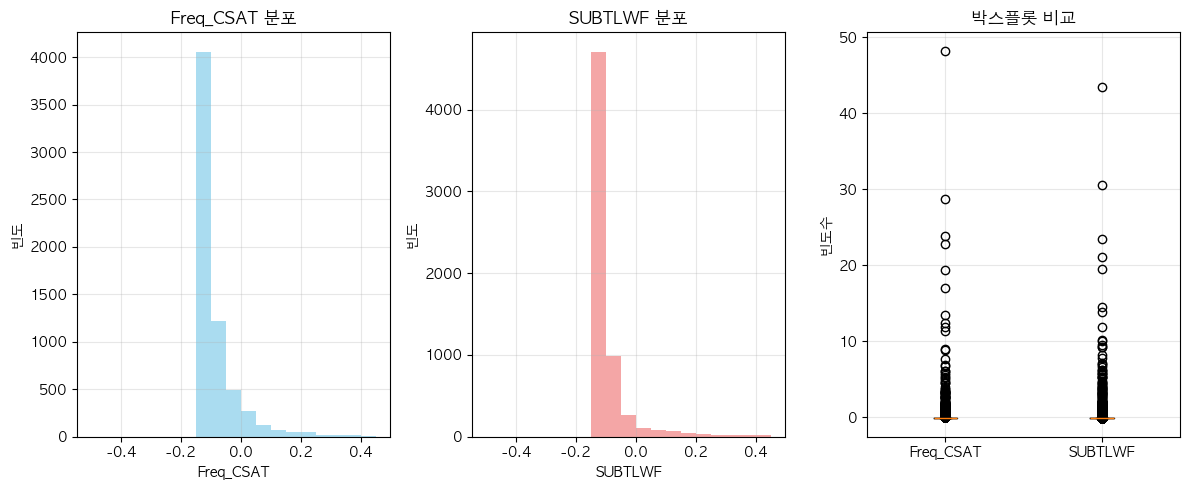

In [271]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT', 'SUBTLWF', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
Ortho_N - 평균: -0.00, 표준편차: 1.00
Orthographic_N_CSAT - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8706 (p-value: 0.0000)
스피어만 상관계수: 0.7875 (p-value: 0.0000)
켄달 타우: 0.7236 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


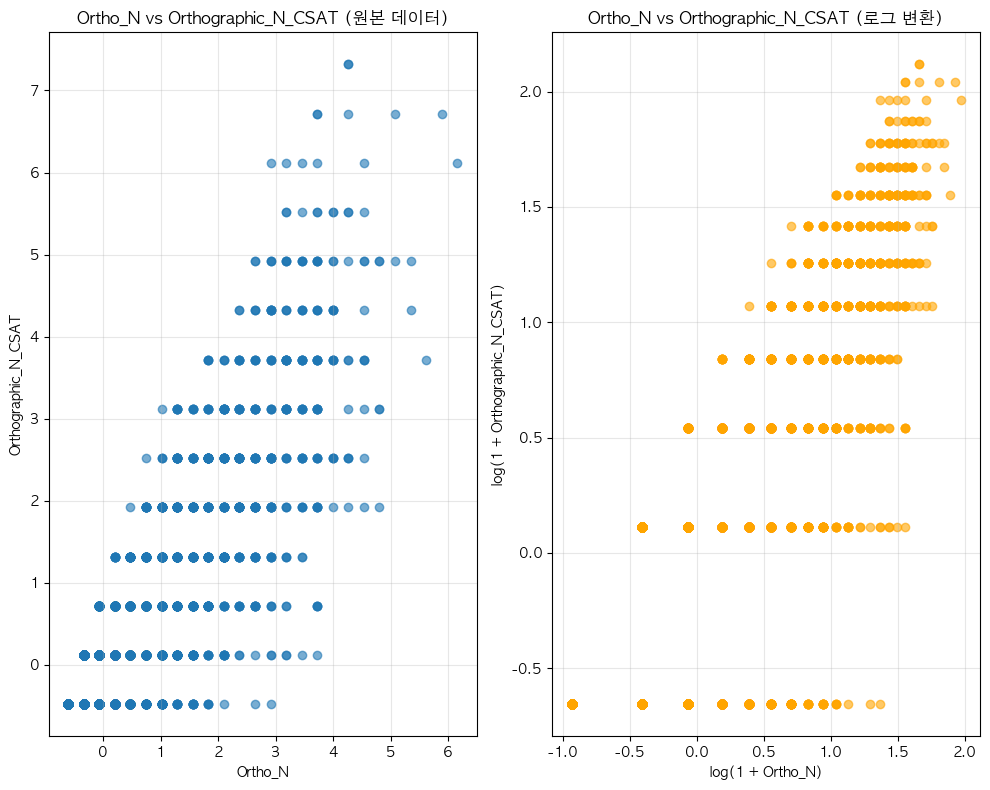

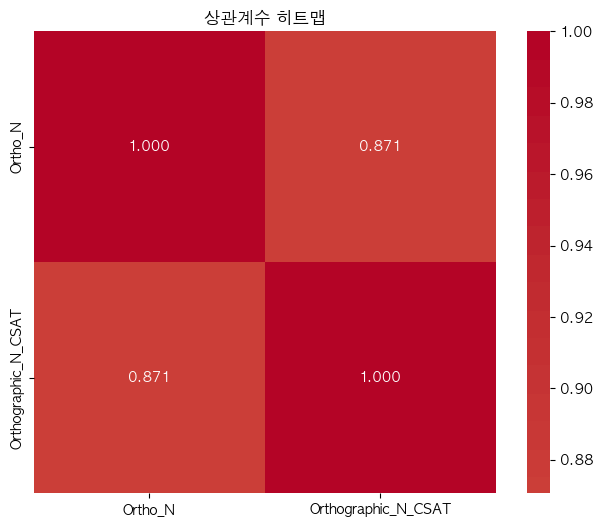

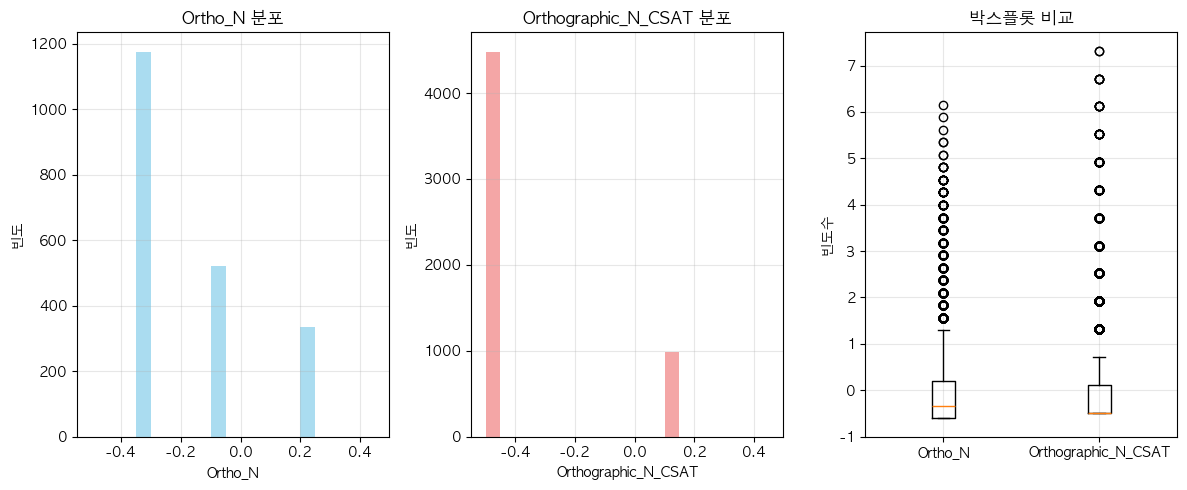

In [320]:
analyzer = analyze_word_frequency_correlation(new_df, 'Ortho_N', 'Orthographic_N_CSAT', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6589
OLD - 평균: 0.00, 표준편차: 1.00
OLD20_CSAT - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9615 (p-value: 0.0000)
스피어만 상관계수: 0.9647 (p-value: 0.0000)
켄달 타우: 0.8509 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


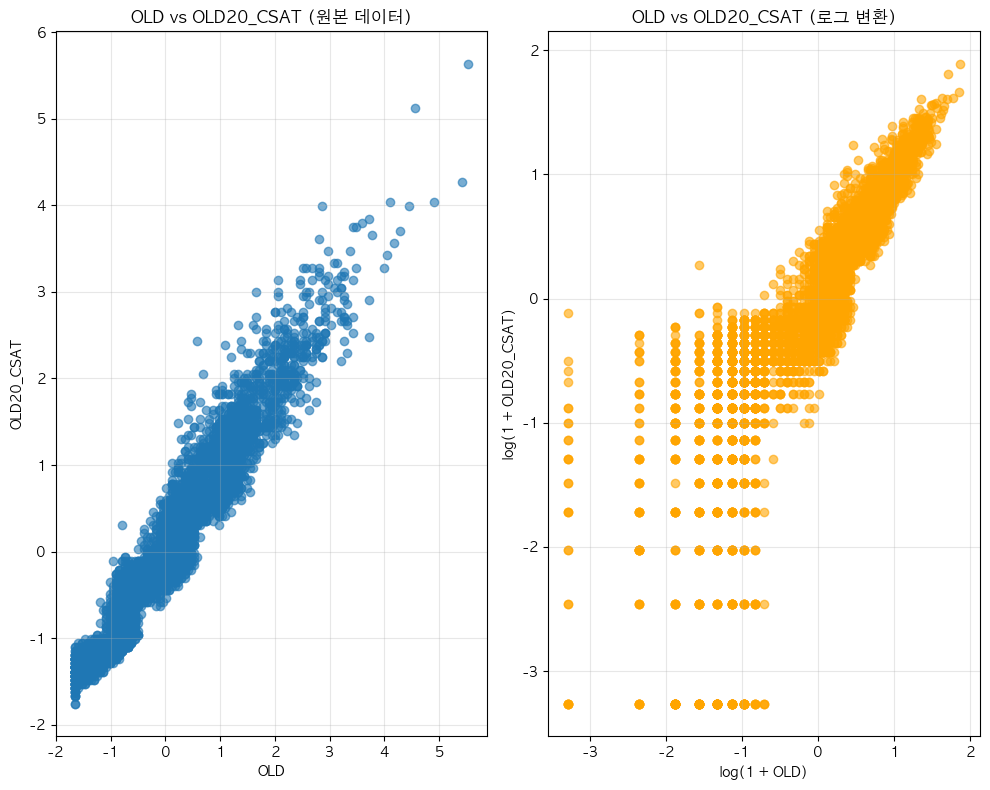

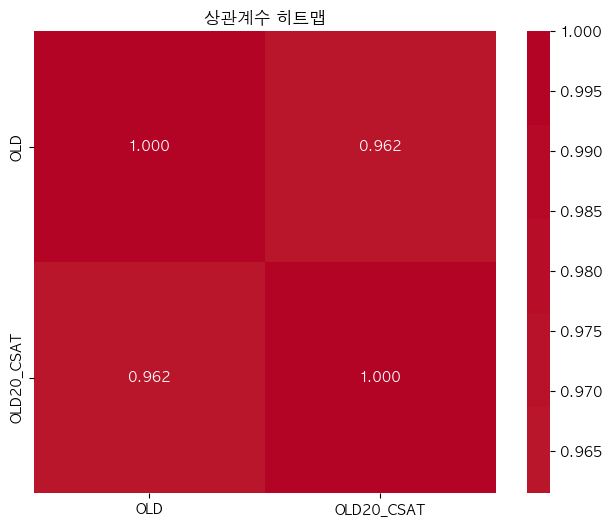

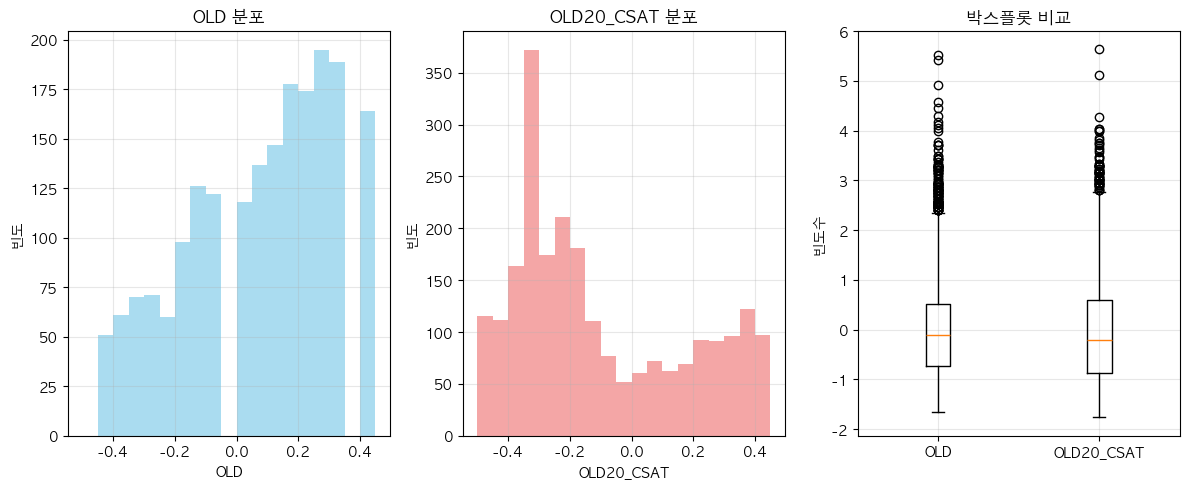

In [322]:
analyzer = analyze_word_frequency_correlation(new_df, 'OLD', 'OLD20_CSAT', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

# Levenshtein distance

In [ ]:
# CSAT Corpus 내의 단어들을 lexicon 취급
lexicon = new_df['Word'].values

In [310]:
from Levenshtein import distance # distance measure function import

def orthographic_N(word : str, lexicon : list[str]) -> int: # orthographic N의 정의를 이용해서 이웃의 개수 산출.
    # 길이는 고정해두었기 때문에, levenshtein에서 허용하는 건 치환만. 또한, distance=1으로, 스스로는 제외
    return sum(1 for w in lexicon if len(w)==len(word) and distance(w, word)==1) 

def OLD20(word : str, lexicon : list[str]) -> float:
    dists = sorted(distance(word, w) for w in lexicon)[:20]
    return np.mean(dists).item()



In [313]:
new_df['Orthographic_N_CSAT'] = new_df['Word'].apply(lambda x: orthographic_N(x, lexicon))
new_df['OLD20_CSAT'] = new_df['Word'].apply(lambda x: OLD20(x, lexicon))

In [324]:
new_df.columns

Index(['Word', 'Freq_CSAT', 'LogE_Freq_CSAT', 'Log10_Freq_CSAT', 'Length',
       'Freq_HAL', 'Log_Freq_HAL', 'SUBTLWF', 'LgSUBTLWF', 'Ortho_N', 'OLD',
       'OLDF', 'Orthographic_N_CSAT', 'OLD20_CSAT'],
      dtype='object')

In [325]:
reindex_order = ['Word', 'Length', 'Freq_CSAT', 'LogE_Freq_CSAT', 'Log10_Freq_CSAT', 'Orthographic_N_CSAT', 'OLD20_CSAT', 
       'Freq_HAL', 'Log_Freq_HAL', 'SUBTLWF', 'LgSUBTLWF', 'Ortho_N', 'OLD',
       'OLDF']

new_df = new_df.reindex(columns=reindex_order)

In [326]:
new_df.to_excel('./corpus/merged_corpus.xlsx', index=False)